<a href="https://colab.research.google.com/github/Jayden-Cho/Datathon-2021/blob/main/Datathon_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Create a folder called 'Datathon2021' in your google drive and put our data and Run.
2. If you execute the cell below, you will see the link. Click the Link and get the access for your google drive. You will be able to mount.

In [ ]:
from os import path
from google.colab import drive

notebook_dir_name = 'Datathon2021'
drive.mount('/content/drive')
notebooks_base_dir = path.join('./gdrive/My Drive/', notebook_dir_name)
if not path.exists(notebooks_base_dir):
  print('Check')
drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Check
Mounted at /content/drive


In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel
!pip install pyclustering

Requirement already up-to-date: ipykernel in /usr/local/lib/python3.7/dist-packages (5.5.0)


In [ ]:
# Data analysis libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mlp
import datetime
from collections import Counter

# Machine Learning libraries
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Extra tools for cluster analysis
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import read_sample

# Exploratory Data Analysis

Firstly, we started off by loading the data into the notebook.
In order to preserve seconds in "Timestamp" column, we converted the csv file into xlsx file format.

In [ ]:
SheetPull = pd.read_excel('/content/drive/MyDrive/Datathon2021/SheetPullData.xlsx')
Demographic = pd.read_csv('/content/drive/MyDrive/Datathon2021/DemographicData.csv')
SheetPull

,HH_ID,Roll_ID,Roll_Type,Timestamp,Time_since_last_pull,Sheets
0,A,1207,Small,2019-09-28 16:08:03,6266,4.479940
1,A,1207,Small,2019-09-28 16:08:04,1,0.955735
2,A,1207,Small,2019-09-28 16:08:06,2,0.159143
3,A,1207,Small,2019-09-28 16:08:16,10,1.112836
4,A,1207,Small,2019-09-28 16:10:20,124,3.642079
...,...,...,...,...,...,...
12780,D,7595,Small,2020-09-01 06:10:14,15427,2.806862
12781,D,7595,Small,2020-09-01 06:10:28,14,2.544244
12782,D,7595,Small,2020-09-01 08:04:17,6829,2.738380
12783,D,7595,Small,2020-09-01 08:04:19,2,0.546555


Since negative numbers affect the later scaling of the dataset, we decided to replace negative values of `Sheets` with 0.

In [ ]:
for i in range(len(SheetPull)):
  if SheetPull['Sheets'][i] < 0:
    SheetPull['Sheets'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Before doing anything else, we checked if there is any missing values in the table, and looked at the summary of the dataframe to see if there is any peculiar value.

In [ ]:
SheetPull.isnull().sum()

HH_ID                   0
Roll_ID                 0
Roll_Type               0
Timestamp               0
Time_since_last_pull    0
Sheets                  0
dtype: int64

We defined a function that gives the task number to consecutive pulls because although they are recorded as different data entry, they are highly likely to be the same task if one pull happened right after another.


- Since the rows are not exactly in order in terms of time, we sort the DataFrame by time.

- Then, stable sort again by Roll ID and Household ID to keep them gruoped by Roll ID and Household ID.

In [ ]:
def assign_task_num(time_threshold, df):
  sorted_df = df.copy().sort_values('Timestamp').sort_values('Roll_ID',kind='mergesort').sort_values('HH_ID',kind='mergesort',ignore_index=True) # sort by time
  sorted_df['Timestamp'] = pd.to_datetime(sorted_df['Timestamp']) # convert Timestamp to datetime objects

  sorted_df['Task'] = 0
  sorted_df.reset_index(drop=True, inplace=True)
  
  task = 0
  for i in range(sorted_df.shape[0]): # group sheet pulls by Time_since_last_pull
    sorted_df['Task'][i] = task
    if i==sorted_df.shape[0]-1:
      continue
    if sorted_df['Roll_ID'][i] != sorted_df['Roll_ID'][i+1] or sorted_df['HH_ID'][i]!=sorted_df['HH_ID'][i+1] or sorted_df['Time_since_last_pull'][i+1] > time_threshold:
      task+=1
  return sorted_df

Now, we give each row sheet pulls a task number.

- Before doing so, we separated the dataframe into 4 different DataFrames.

- The main rationale behind it was the fact the the members of the households show different gender distribution, and are in different age groups. Also, in general, toilet paper usages of the same type of toilet task can vary a lot depending on the individual.

In [ ]:
HH_A = SheetPull[SheetPull['HH_ID']=='A']
HH_B = SheetPull[SheetPull['HH_ID']=='B']
HH_C = SheetPull[SheetPull['HH_ID']=='C']
HH_D = SheetPull[SheetPull['HH_ID']=='D']

In order to find the optimal time threshold to group tasks togerther, we assigned task numbers to each DataFrame by different time threshold, starting from 30 seconds to 360 seconds.

In [ ]:
num_tasks_A = []
num_tasks_B = []
num_tasks_C = []
num_tasks_D = []

for t in range(30, 361, 30):
  num_task_A = assign_task_num(t, HH_A)['Task'].max()
  num_task_B = assign_task_num(t, HH_B)['Task'].max()
  num_task_C = assign_task_num(t, HH_C)['Task'].max()
  num_task_D = assign_task_num(t, HH_D)['Task'].max()

  num_tasks_A.append(num_task_A)
  num_tasks_B.append(num_task_B)
  num_tasks_C.append(num_task_C)
  num_tasks_D.append(num_task_D)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Then we drew line plot to visualize what differences the changes in time threshold can make.

Text(0, 0.5, 'Number of tasks')

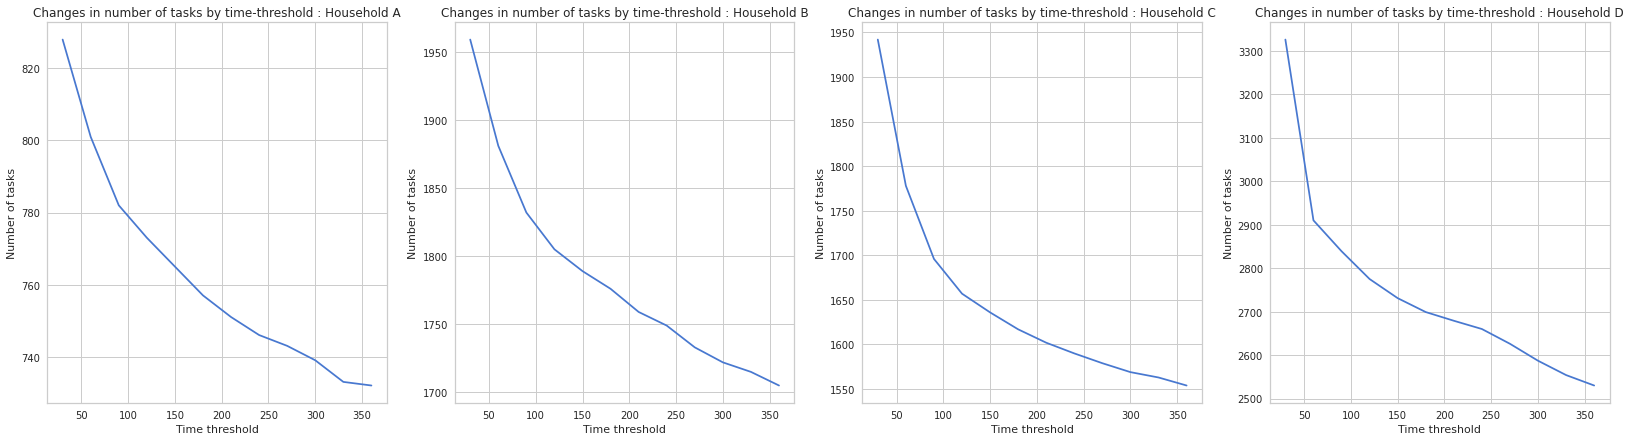

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(28,7))
x = list(range(30, 361, 30))
plt.subplot(1, 4, 1)
plt.plot(x, num_tasks_A)
plt.title('Changes in number of tasks by time-threshold : Household A')
plt.xlabel('Time threshold')
plt.ylabel('Number of tasks')

plt.subplot(1, 4, 2)
plt.plot(x, num_tasks_B)
plt.title('Changes in number of tasks by time-threshold : Household B')
plt.xlabel('Time threshold')
plt.ylabel('Number of tasks')

plt.subplot(1, 4, 3)
plt.plot(x, num_tasks_C)
plt.title('Changes in number of tasks by time-threshold : Household C')
plt.xlabel('Time threshold')
plt.ylabel('Number of tasks')

plt.subplot(1, 4, 4)
plt.plot(x, num_tasks_D)
plt.title('Changes in number of tasks by time-threshold : Household D')
plt.xlabel('Time threshold')
plt.ylabel('Number of tasks')

As shown in the graphs above, the number of tasks decreases rapidly in the beginning, and starts to level out as the time threshold increases. 
- We picked points where the slope of the graph starts to decrease noticeably. And we agreed upon using the following numbers as the time threshold for each household.

In [ ]:
time_threshold_A = 90 
time_threshold_B = 120
time_threshold_C = 120
time_threshold_D = 60

We have grouped the rows by task, and now will add more features that are derived from the given data.

- The new columns will be as follows:

`HH_ID`: Household ID

`start_time` : Timestamp of the first sheet pull in a task.

`end_time` : Timestamp of the last sheet pull in a task.

`delta_time` : The difference of the start_time and end_time.

`Time_mins`: Time of the day in minutes. (0 minutes to  24 * 60 minutes)

`Time_since_last_pull` : Elapsed time from last task's last pull to new task's first pull.

`num_sheet_pulls` : Total number of pulls in a task.

`total_sheets` : Total amount of sheets pulled in a task.

`avg_sheets` : Average amount of sheets pulled in a task.

`max_sheets` : Max amount of sheets pulled in a task.



During the observation, we have figured out significant peculiarities of the dataset.
1. There is a huge time difference in the transition of `Roll_Type`. With this information, we assumed that there are two different places and two restrooms have each type of tissue roll. To detect this difference, we have sorted the data rame using `Roll_ID`.

2. We have detected the transition between `Roll_ID`. There will be a more detailed explanation in the visualization section.

Major decisions we made on creating dataframe:
1. We decided not to implement `Time_since_last_pull` on modeling. This is because this feature has been replaced as `Time_mins` and there are significant outliers which affect on the clustering process. More importantly, this feature have no effect on household's behaviors and tasks, since it only shows the time differene between the present and previous tasks.

2. We first tried to implement categorical features on clustering. We have detected that the categorical features have a dominant portion on cluster formation, neglecting important features such as `num_sheet_pulls`. 
  - Later we learned that categorical feature is not applicable on K-means algorithm.

In [ ]:
 def generate_new_dataframe(old_df):
  new_df = pd.DataFrame()

  old_df['Timestamp'] = pd.to_datetime(old_df['Timestamp'])
  new_df['Roll_ID'] = old_df.groupby('Task')['Roll_ID'].mean()
  new_df['Roll_Type'] = old_df.groupby('Task')['Roll_Type'].min()
  new_df['start_time'] = old_df.groupby('Task')['Timestamp'].min()
  new_df['end_time'] = old_df.groupby('Task')['Timestamp'].max()
  new_df['delta_time'] = (new_df['end_time'] - new_df['start_time']).dt.total_seconds() / 60
  new_df['Time_mins'] = [(time.hour * 60 + time.minute) for time in pd.Series([val.time() for val in new_df['start_time']])]

  #new_df['Time_since_last_pull'] = old_df.groupby('Task')['Time_since_last_pull'].max()
  new_df['num_sheet_pulls'] = old_df.groupby('Task').count()['Sheets']
  new_df['total_sheets'] = old_df.groupby('Task')['Sheets'].sum()
  new_df['avg_sheets'] = new_df['total_sheets'] / new_df['num_sheet_pulls']
  new_df['max_sheets'] = old_df.groupby('Task')['Sheets'].max()
  le = LabelEncoder()
  new_df['Roll_ID'] = le.fit_transform(new_df['Roll_ID'])
  return new_df

new_A = generate_new_dataframe(assign_task_num(time_threshold_A, HH_A))
new_B = generate_new_dataframe(assign_task_num(time_threshold_B, HH_B))
new_C = generate_new_dataframe(assign_task_num(time_threshold_C, HH_C))
new_D = generate_new_dataframe(assign_task_num(time_threshold_D, HH_D))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


We still get negative value of sheet pulls after grouping data into tasks. There are only a few entries, so we decided to drop those rows.

In [ ]:
new_A = new_A[new_A['total_sheets'] > 0].reset_index(drop=True)
new_B = new_B[new_B['total_sheets'] > 0].reset_index(drop=True)
new_C = new_C[new_C['total_sheets'] > 0].reset_index(drop=True)
new_D = new_D[new_D['total_sheets'] > 0].reset_index(drop=True)
new_A

,Roll_ID,Roll_Type,start_time,end_time,delta_time,Time_mins,num_sheet_pulls,total_sheets,avg_sheets,max_sheets
0,0,Small,2019-10-29 05:51:42,2019-10-29 05:51:42,0.000000,351,1,3.991088,3.991088,3.991088
1,0,Small,2019-10-29 06:33:27,2019-10-29 06:33:27,0.000000,393,1,0.477180,0.477180,0.477180
2,0,Small,2019-10-29 07:13:21,2019-10-29 07:13:21,0.000000,433,1,4.277735,4.277735,4.277735
3,0,Small,2019-10-29 11:10:01,2019-10-29 11:10:01,0.000000,670,1,2.363388,2.363388,2.363388
4,0,Small,2019-10-29 11:23:49,2019-10-29 11:23:53,0.066667,683,2,2.980160,1.490080,2.665750
...,...,...,...,...,...,...,...,...,...,...
771,8,Big,2020-06-20 07:11:59,2020-06-20 07:11:59,0.000000,431,1,4.183706,4.183706,4.183706
772,8,Big,2020-06-20 15:27:10,2020-06-20 15:27:29,0.316667,927,6,16.512266,2.752044,9.471123
773,8,Big,2020-06-20 15:31:48,2020-06-20 15:32:30,0.700000,931,8,16.429508,2.053689,7.487301
774,8,Big,2020-06-21 00:59:02,2020-06-21 00:59:02,0.000000,59,1,9.194302,9.194302,9.194302


# Visualization

## Distribution Plot of Each Household by Roll Type



**Household A: Young married couple working from home**

Text(0.5, 17.6, 'Hours')

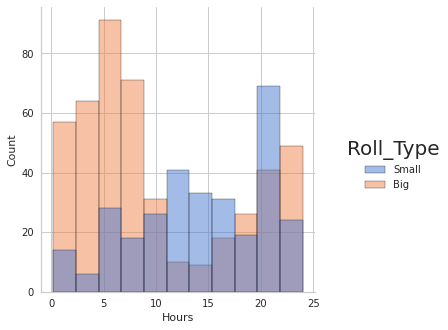

In [ ]:
sns.displot(new_A, x=new_A["Time_mins"]/60, hue="Roll_Type")
plt.xlabel("Hours")

Findings on observation:
- Big roll has been dominantly used in the morning, while small roll has an even distribution with the increase of usage in the evening.
  - We assumed that a big roll had been used on the 2nd-floor restroom, and small on the 1st-floor restroom.
- We also assumed that household A is a married couple working from home. 
  - We can assume that they spend most of their working, instead of going to work, on the 1st floor and spend the rest of the day on the 2nd floor. 
- In short, they handle their tasks on the 2nd-floor restroom in the morning and late-night and use the 1st-floor restroom when they have their dinner in the early night.
  - This might be a reason for the increase in small roll usage in the evening.

**Household B: Middle-aged married couple after retirement**

Text(0.5, 17.6, 'Hours')

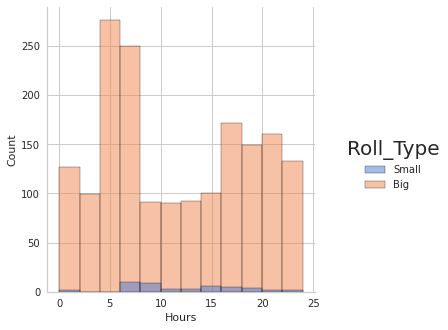

In [ ]:
sns.displot(new_B, x=new_B["Time_mins"]/60, hue="Roll_Type")
plt.xlabel("Hours")

Findings on observation: 

- Remarkably small amount of small roll usage.
  - We will explain later, but this small roll usage accounts for the presense of the guest.
  - Since the guest had been stayed for about a month, relatively small interval compared to the entire dataset, the amount usage of small roll is significantly lower than that of big roll.

- The graph shows that absence of tissue usage during the afternoon.
  - We can assume that household B is very active and they usually spend their afternoon outside of the house.

**Household C: Old-aged married couple spending their most time at home**

Text(0.5, 17.6, 'Hours')

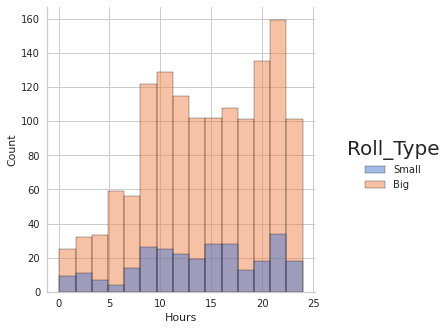

In [ ]:
sns.displot(new_C, x=new_C["Time_mins"]/60, hue="Roll_Type")
plt.xlabel("Hours")

Findings on observation:
- The graph shows the drastic difference between daytime and bedtime.
  - This difference supports that household C has a firm life pattern.


**Household D: One goes to work, the other stays at home**

Text(0.5, 17.6, 'Hours')

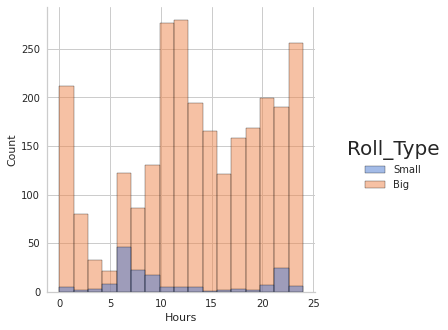

In [ ]:
sns.displot(new_D, x=new_D["Time_mins"]/60, hue="Roll_Type")
plt.xlabel("Hours")

Findings on observation:
- Relatively low usage of small roll compared to big roll.
  - It is interesting that small roll usage is at its peak in the morning.
  - Later we will explain but we assume that one person goes to work while the other stays at home. This peculiar distribution of small roll may indicate that small roll is for the person who goes to work.
- Shift of the graph.
  - They usually go to bed in the daybreak, and the time of peak usage is shifted left compared to the other households.

- Small dots : Big Roll
- Large dots : Small Roll

## `relplot()`: Different method for visualization

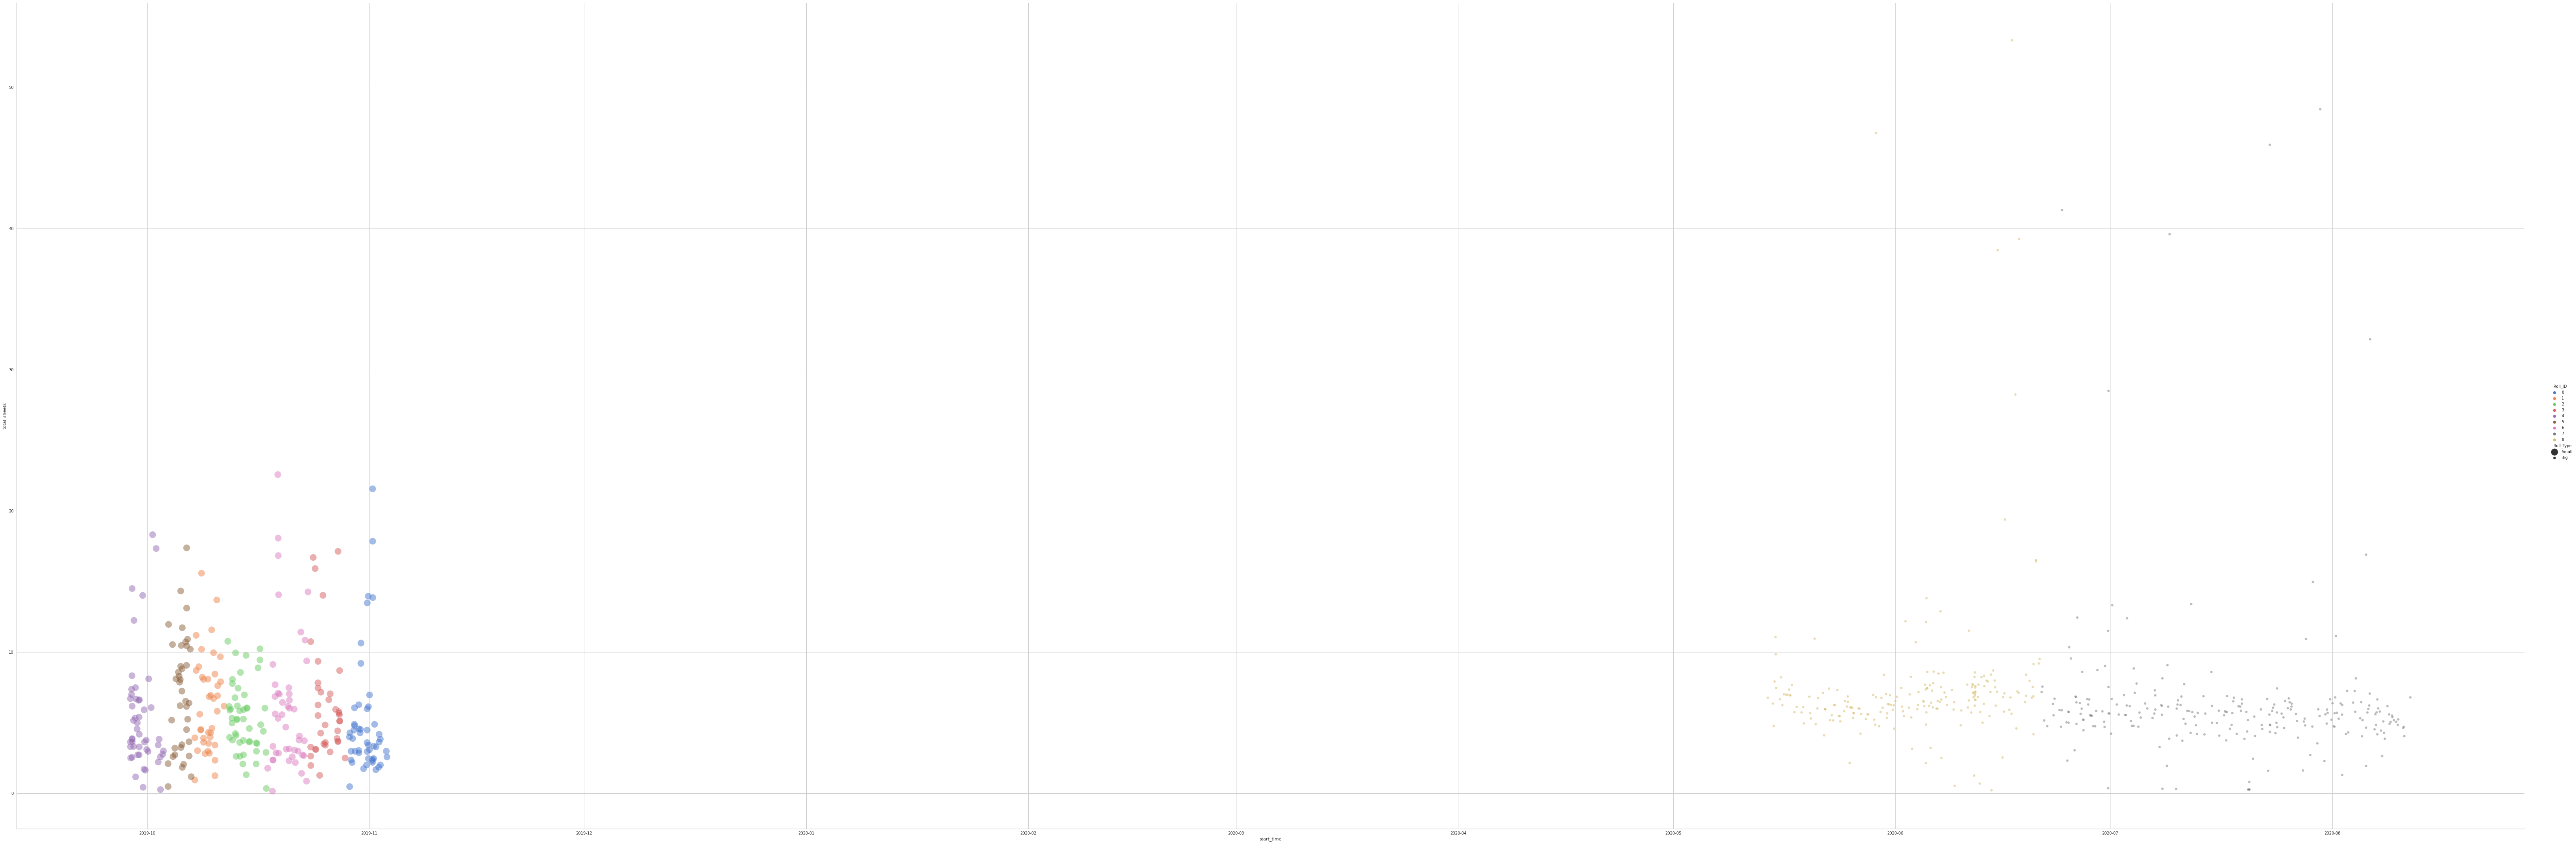

In [ ]:
sns.relplot(x="start_time", y="total_sheets", hue="Roll_ID", size="Roll_Type",
            sizes=(40, 300), alpha=.5,  palette='muted',  
            height=30, aspect=3, data=new_A)

This graph proves that different types of tissue rolls don't affect different task behaviors.

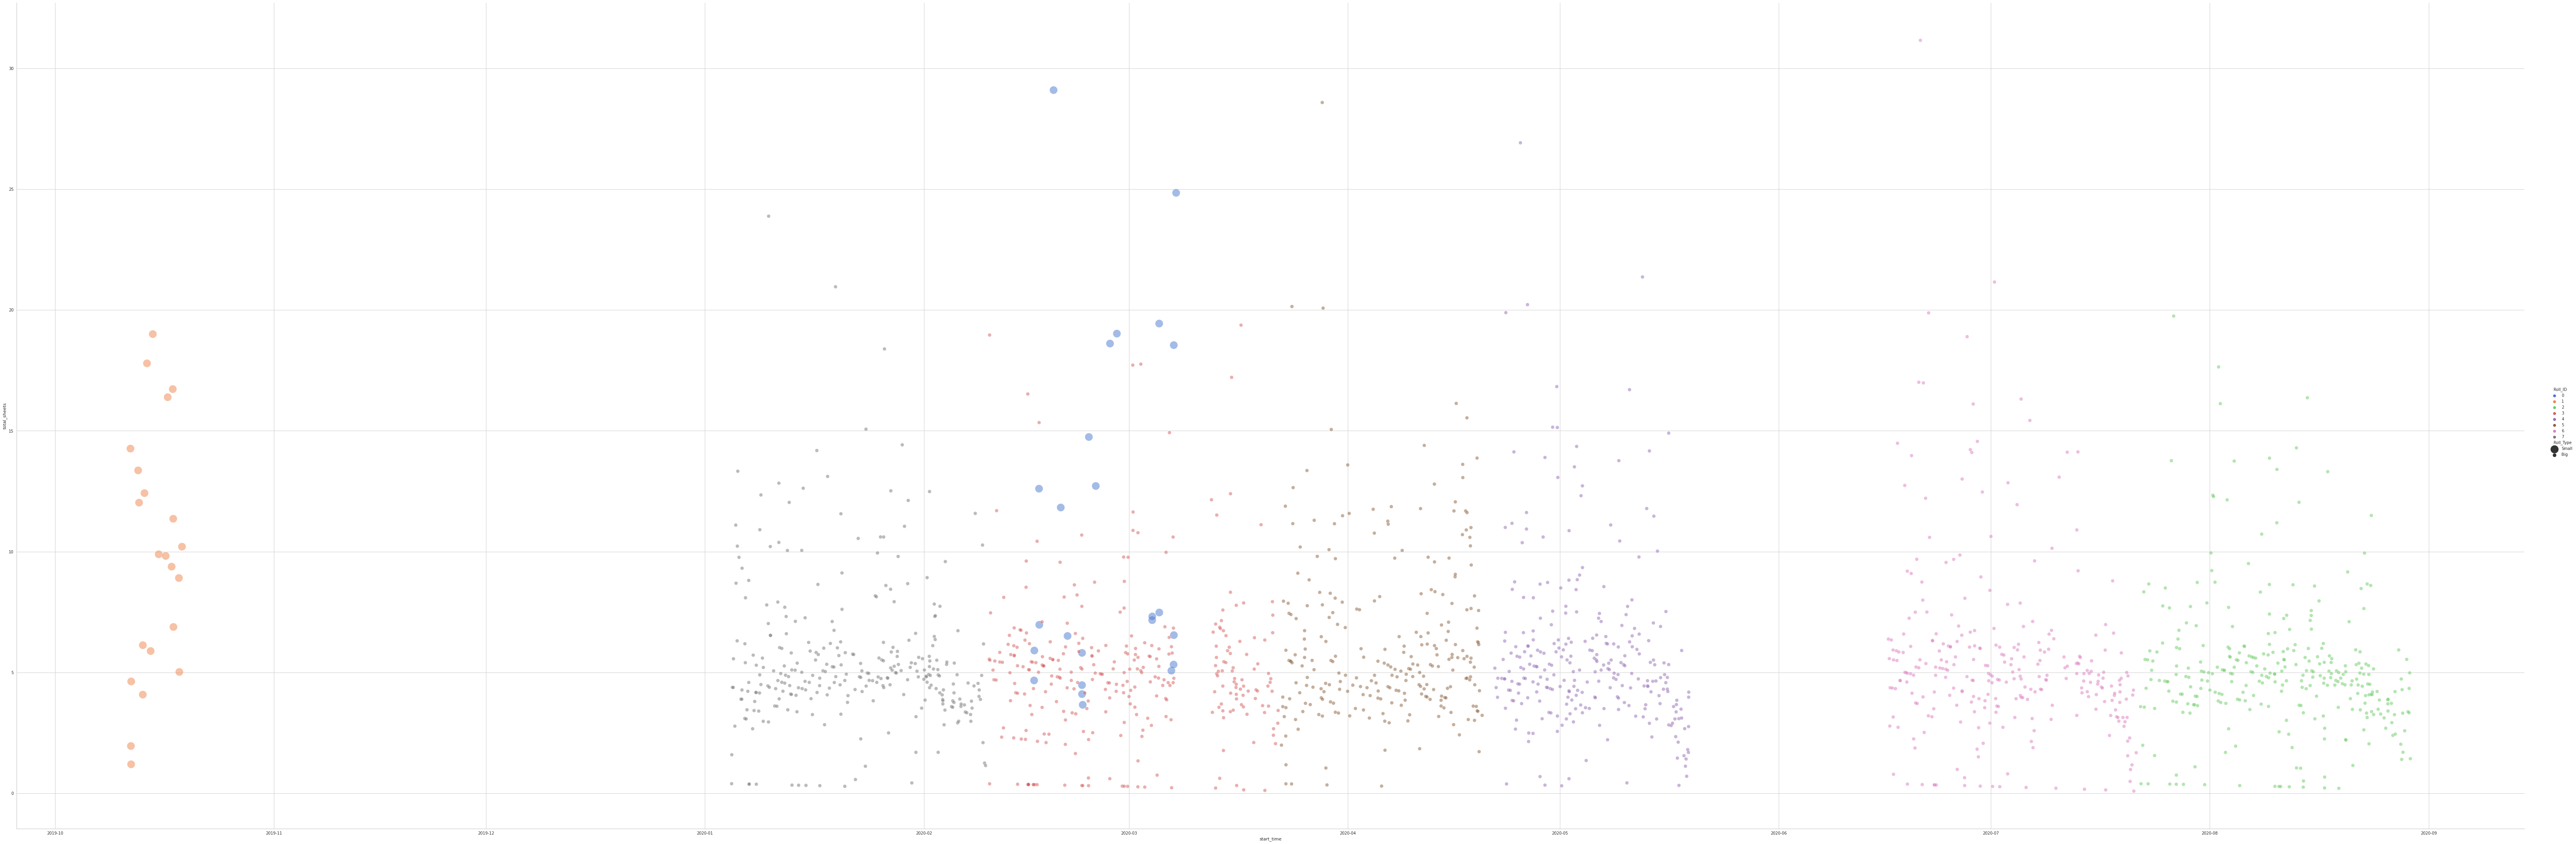

In [ ]:
sns.relplot(x="start_time", y="total_sheets", hue="Roll_ID", size="Roll_Type",
            sizes=(80, 400), alpha=.5,  palette='muted',
            height=30, aspect=3, data=new_B)

Interestingly, there are sudden usage of small roll between February and March.
- We labelled this as a presense of the guest for that period.
- Except that speical period, there are no overlappings between small and big roll usage.

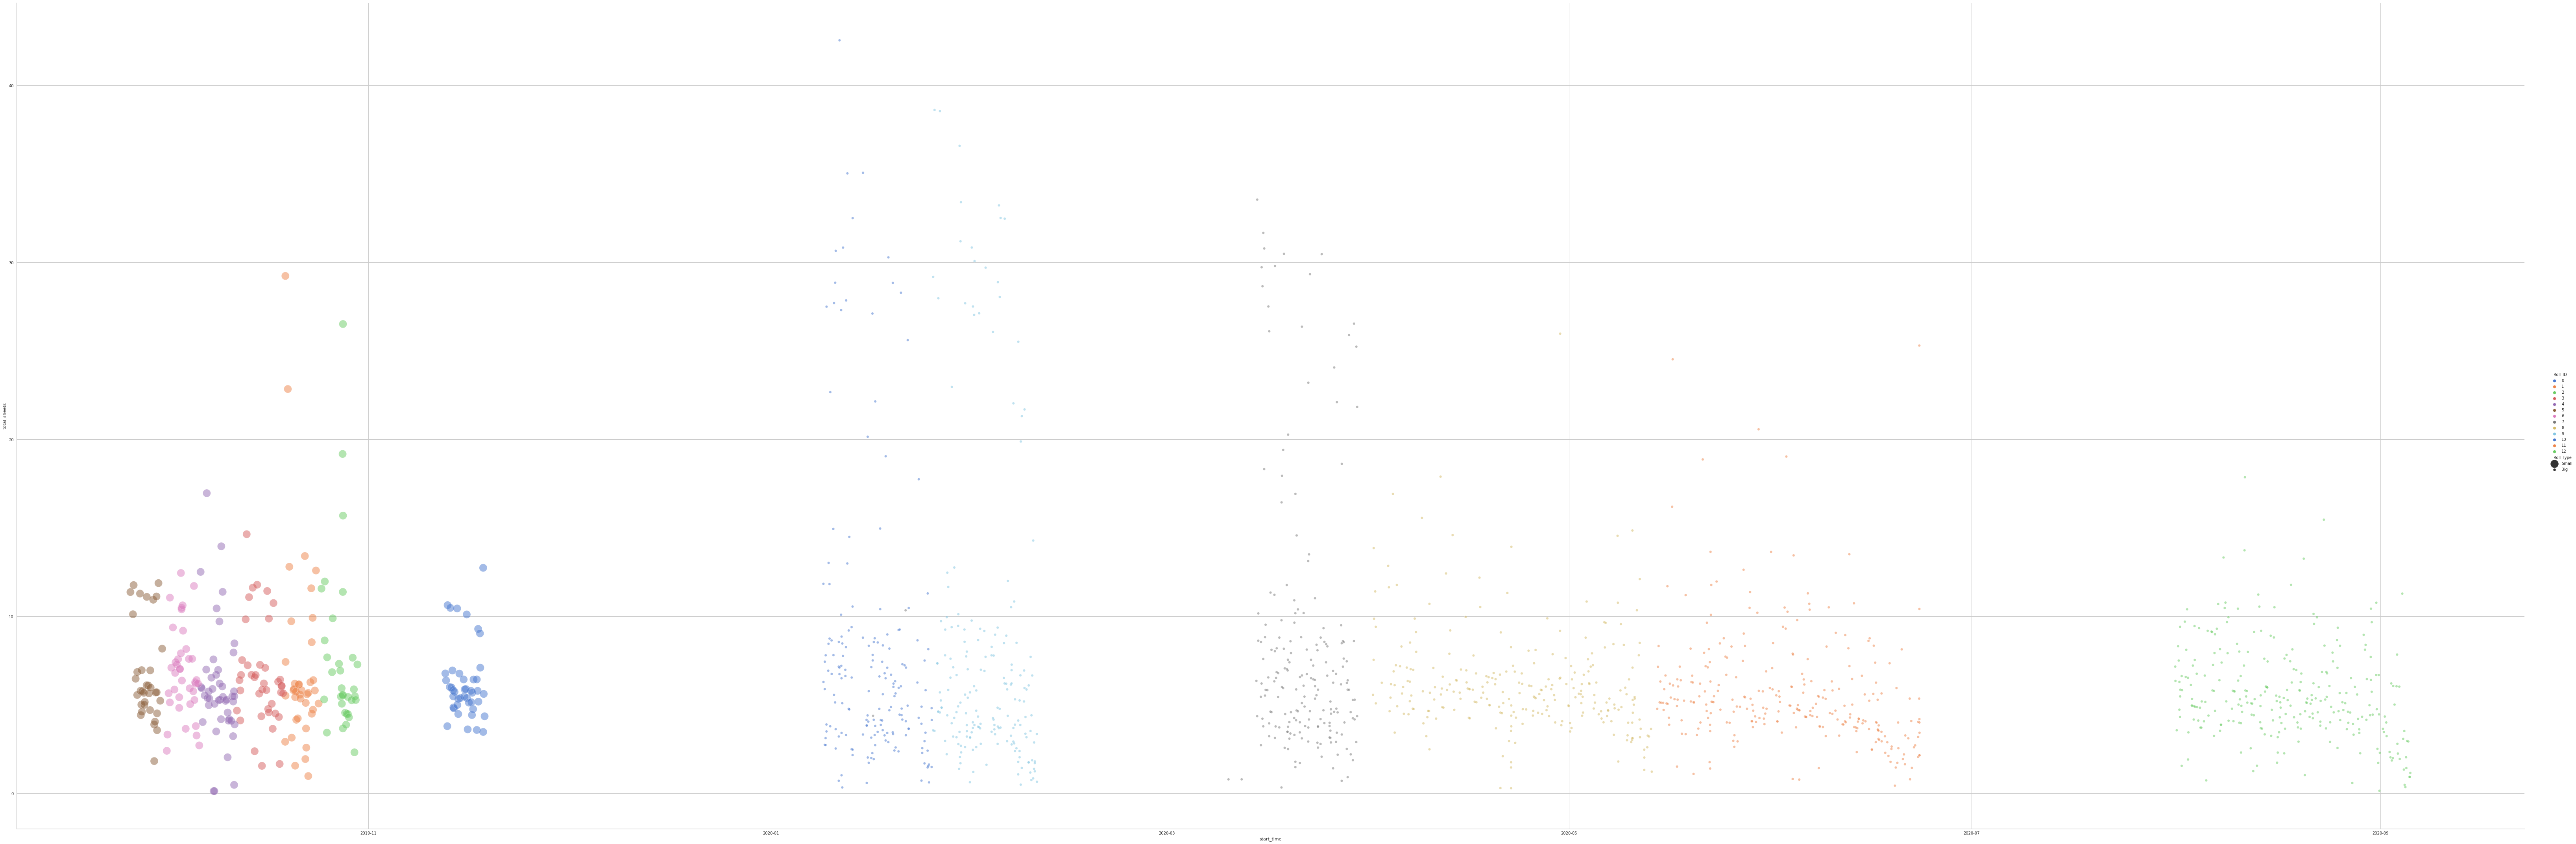

In [ ]:
sns.relplot(x="start_time", y="total_sheets", hue="Roll_ID", size="Roll_Type",
            sizes=(40, 400), alpha=.5,  palette='muted',
            height=30, aspect=3, data=new_C)

Household C shows a relatively even distribution of toilet paper usage over the entire data collection period. Except that small rolls are used in 2019 and big rolls are used in 2020, there was no clear trend shown in the graph.

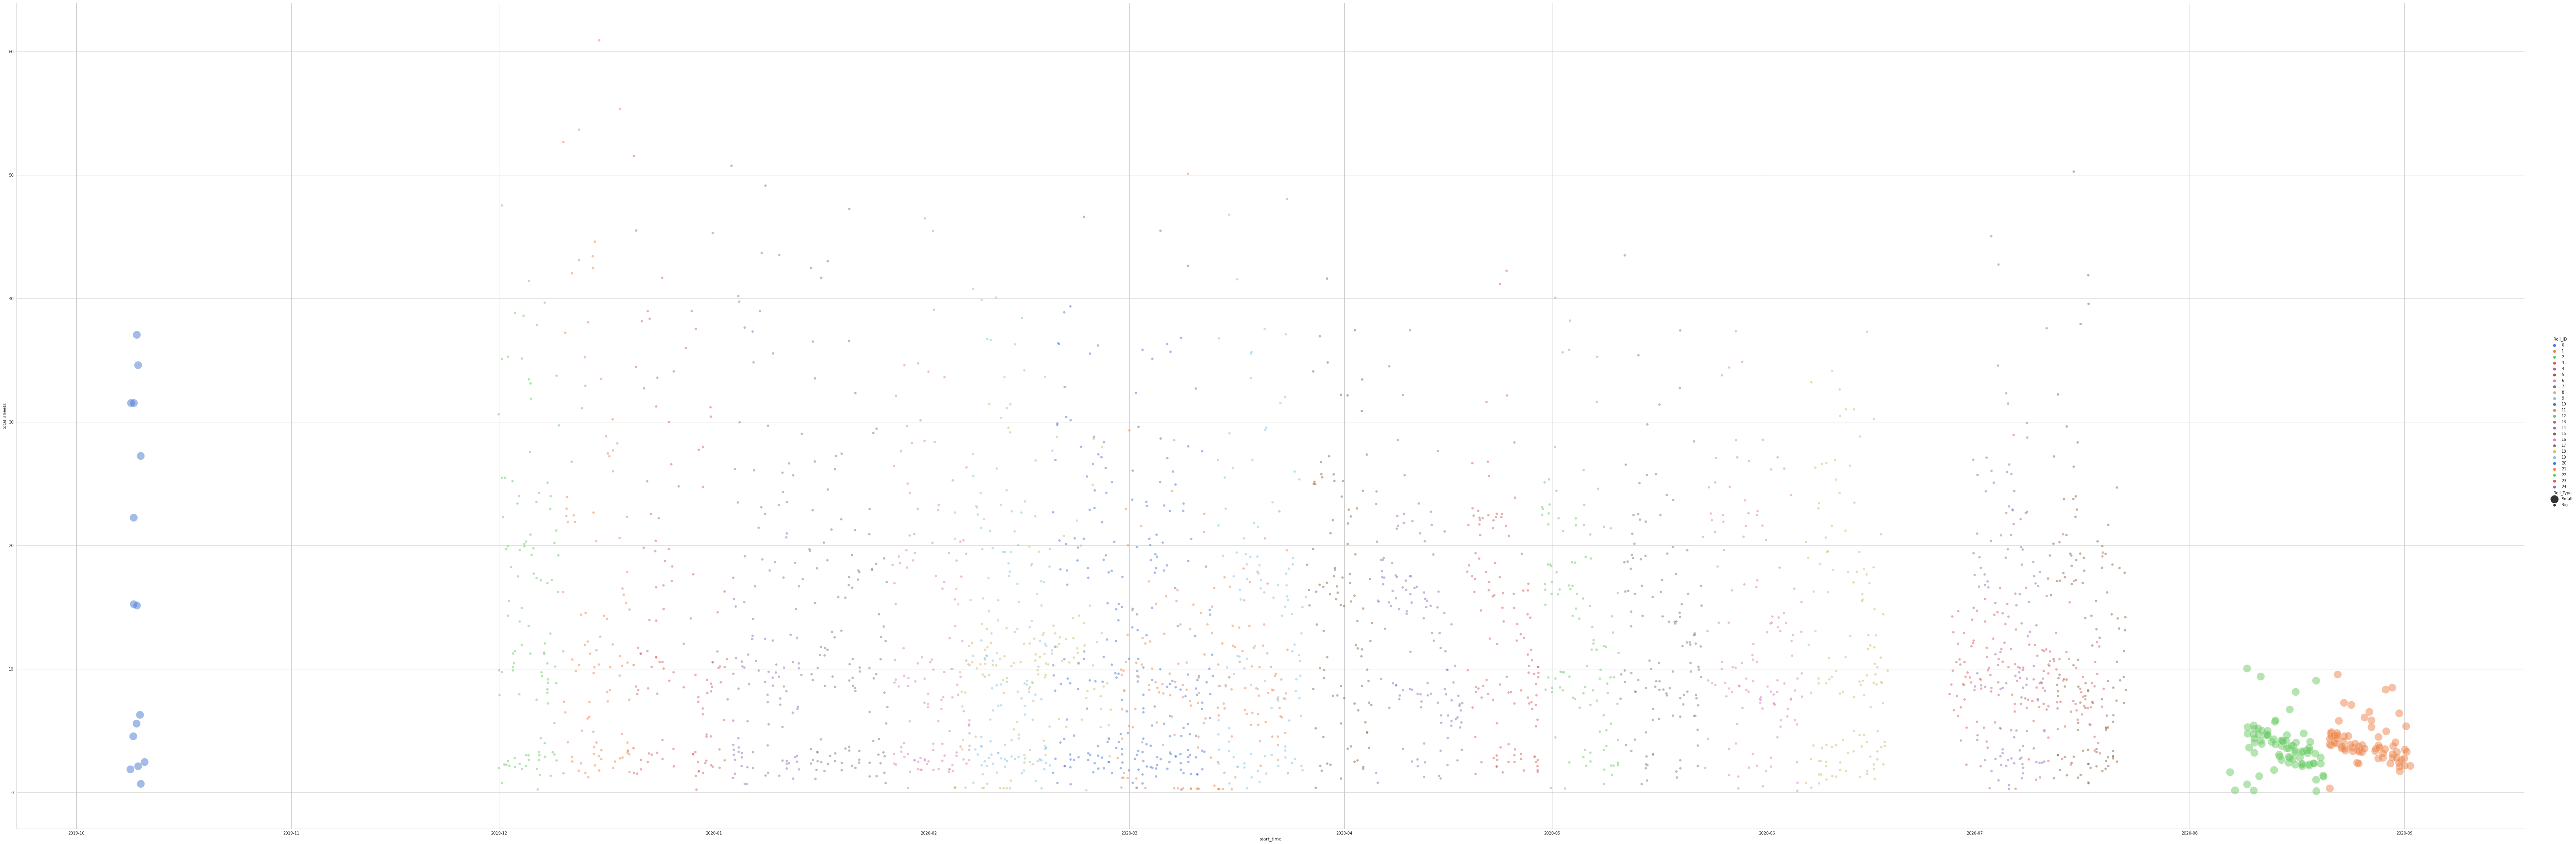

In [ ]:

sns.relplot(x="start_time", y="total_sheets", hue="Roll_ID", size="Roll_Type",
            sizes=(40, 400), alpha=.5,  palette='muted',
            height=30, aspect=3, data=new_D)

In the case of household D, we notice some overlapping of toilet paper usage data from two different rolls, which is not found in other households. 
- If you look at the data from February 2020 to March 2020 and in July 2020, we can see that multiple rolls were used at the same time. 
- However, this is not the case for other times. Also, the toilet paper usage slighty increaes in the same period. 
- Therefore we can infer that guests were visinting household D in those time periods.

# Dimention Reduction 

In order to decide the number of clusters in each dataset, we reduced the columns in to 2D using PCA, t-SNE, and UMAP methods.


#Household A Plotting


##PCA

We have applied PCA to visualize the cluster formation.
- Since our made-up dataframe consists of 5 numerical features, dimension must be reduced to 2. We dropped IDs and datetime features.

In [ ]:
new_A_Time = new_A['Time_mins']
new_HH_A=new_A.drop(columns=['start_time','end_time','Roll_ID', 'Roll_Type', 'Time_mins'], axis=1)
num_features = ['delta_time','Time_since_last_pull','num_sheet_pulls','total_sheets','avg_sheets','Time_mins', 'max_sheets']



Since `total_sheets` feature consists of relatively large numbers, we need to apply scaler.
- We have applied `MinMaxScaler()` since most of the features don't have gaussian distribution.
  - Replacing negative numbers to 0 is to implement `MinMaxScaler()` properly.
  - The other option would be `StandardScaler()`, but as mentioned above, it requires the feature to have a standard distribution.

In [ ]:
#Scaling 
scaler_A = MinMaxScaler()
result = scaler_A.fit_transform(new_HH_A)
data_scaled_A = pd.DataFrame(result, columns=new_HH_A.columns)
data_scaled_A

,delta_time,num_sheet_pulls,total_sheets,avg_sheets,max_sheets
0,0.000000,0.000000,0.072057,0.201451,0.199210
1,0.000000,0.000000,0.005943,0.019182,0.016430
2,0.000000,0.000000,0.077451,0.216319,0.214120
3,0.000000,0.000000,0.041432,0.117021,0.114543
4,0.023669,0.111111,0.053037,0.071722,0.130271
...,...,...,...,...,...
771,0.000000,0.000000,0.075681,0.211442,0.209229
772,0.112426,0.555556,0.307644,0.137181,0.484260
773,0.248521,0.777778,0.306086,0.100957,0.381069
774,0.000000,0.000000,0.169956,0.471344,0.469861


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


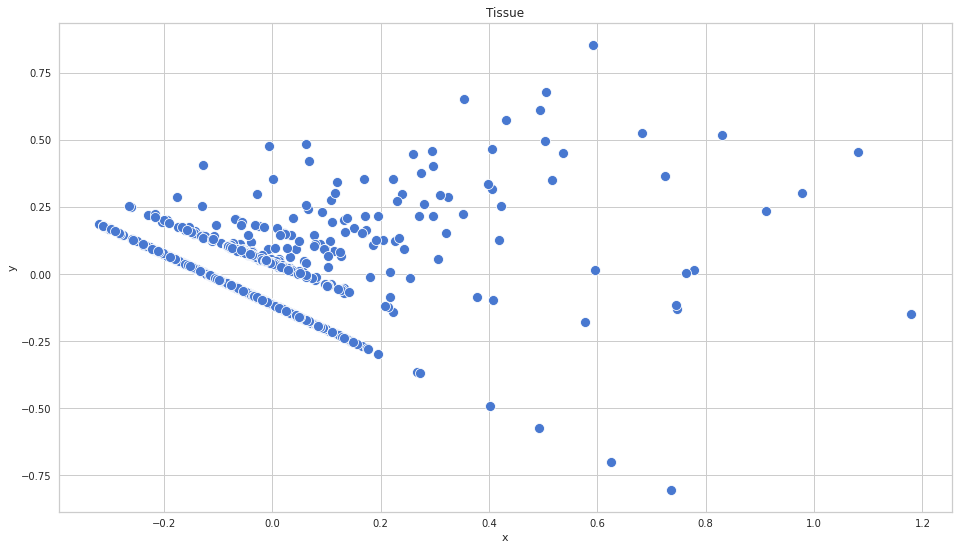

In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(data_scaled_A)
result = pd.DataFrame(result, columns=["x", "y"])

# font define
mlp.rcParams['font.size'] = 20
mlp.rcParams['font.family'] = 'Nanum Gothic'

# visualization
plt.figure(figsize=(16, 9))
sns.set_palette(sns.color_palette("muted"))

sns.scatterplot(result['x'], 
                     result['y'],
                     s=100,
                    )
plt.title('Tissue')
plt.show()

The main disadvantage of PCA is data loss.
- The distribution of the tasks is not very clear to examine the shape of clusters.

##TSNE

The other way to visualize the cluster by dimension reudction is t-distributed stochastic neighbor embedding, called t-SNE.

- t-SNE converts similarities between data points to joint probabilities and tries to minimize the divergence between the probabilities of the high-dimensional data.

Two important parameters of t-SNE:
- `perplexity`: Cluster contains more neighbors as the number increases. 
- `early_exaggeration`: It controls the distance on the plot among neighbors.

Text(0, 0.5, 't-SNE Feature 1')

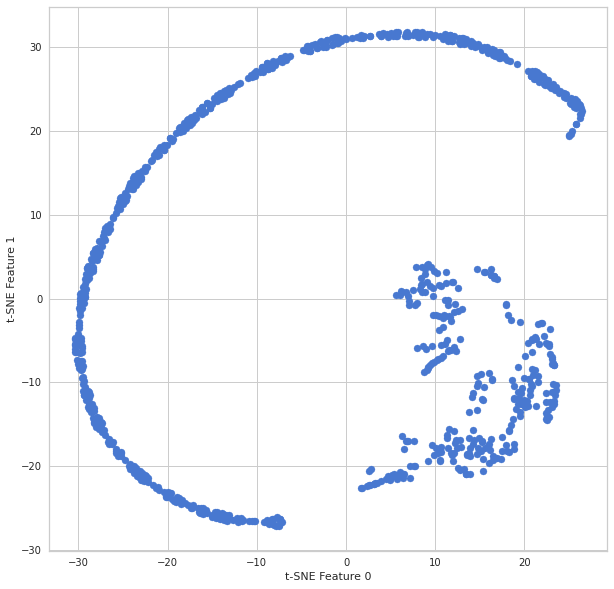

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42, early_exaggeration=10)
df_tsne = tsne.fit_transform(data_scaled_A)
df_tsne = pd.DataFrame(df_tsne, columns=['First Feature', 'Second Feature'])

plt.figure(figsize=(10, 10))
plt.scatter(df_tsne['First Feature'], df_tsne['Second Feature'])
plt.xlabel('t-SNE Feature 0')
plt.ylabel('t-SNE Feature 1')

Just like PCA, we are not able to check the proper number of cluster with this method. 

##UMAP

UMAP is the dimension reduction tool to model the manifold with a fuzzy topological structure.
- Usually, UMAP returns the best output among the dimension reduction method.

In [ ]:
import umap
import umap.plot
from sklearn.datasets import load_digits

embedding = umap.UMAP().fit_transform(data_scaled_A)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


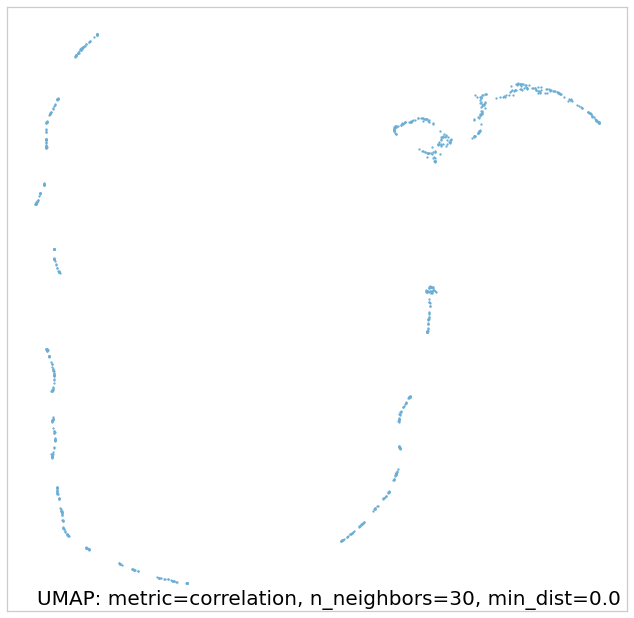

In [ ]:
mapper = umap.UMAP(n_neighbors=30,
                      min_dist=.00,
                      metric='correlation').fit(data_scaled_A)
umap.plot.points(mapper)

The plot is relatively clear than the other dimension reduction method.
- UMAP shows that the number of the cluster for the household is 5.


We assume that the reason why the cluster has a curvy form is that the dataset has a time feature.
However, all the dimension method isn't quite applicable to check for the number of clusters for the dataset.
- Instead, we use the Elbow method and Silhouette method to examine the optimal number of the clusters.

Same processes has been applied to the other households.

#Household B Plotting


In [ ]:
new_B_Time = new_B['Time_mins']
new_HH_B = new_B.drop(columns=['start_time','end_time','Roll_ID', 'Roll_Type', 'Time_mins'], axis=1)

In [ ]:
#Scaling 
scaler_B = MinMaxScaler()
result = scaler_B.fit_transform(new_HH_B)
data_scaled_B = pd.DataFrame(result, columns=new_HH_B.columns)
data_scaled_B.describe()

,delta_time,num_sheet_pulls,total_sheets,avg_sheets,max_sheets
count,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000
mean,0.031904,0.030835,0.180273,0.297656,0.236115
std,0.089986,0.064337,0.113639,0.135677,0.102235
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.122502,0.214380,0.182296
50%,0.000000,0.000000,0.157232,0.305101,0.237200
75%,0.007722,0.071429,0.200830,0.376786,0.288291
max,1.000000,1.000000,1.000000,1.000000,1.000000


##PCA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


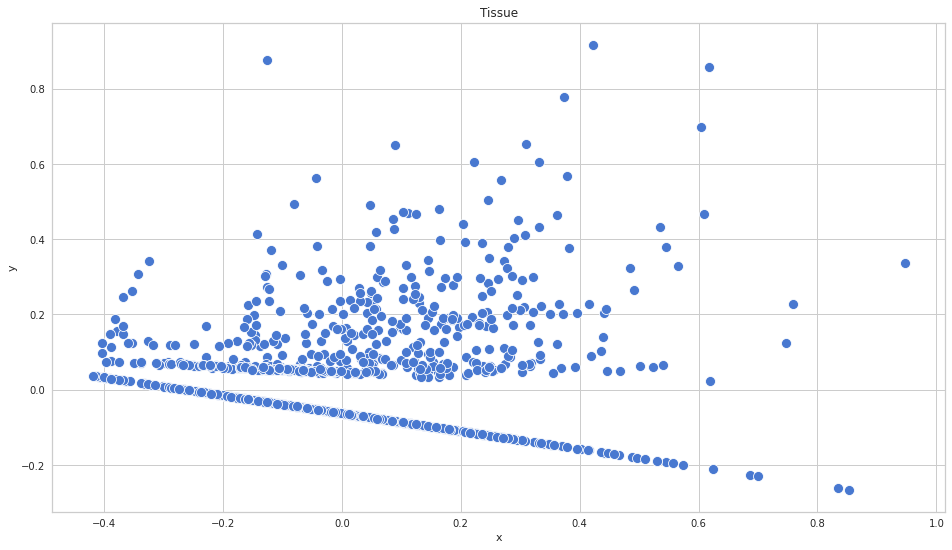

In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(data_scaled_B)
result = pd.DataFrame(result, columns=["x", "y"])

# font define
mlp.rcParams['font.size'] = 20
mlp.rcParams['font.family'] = 'Nanum Gothic'

# visualization
plt.figure(figsize=(16, 9))
sns.set_palette(sns.color_palette("muted"))

sns.scatterplot(result['x'], 
                     result['y'],
                     s=100,
                    )
plt.title('Tissue')
plt.show()

##TSNE

Text(0, 0.5, 't-SNE Feature 1')

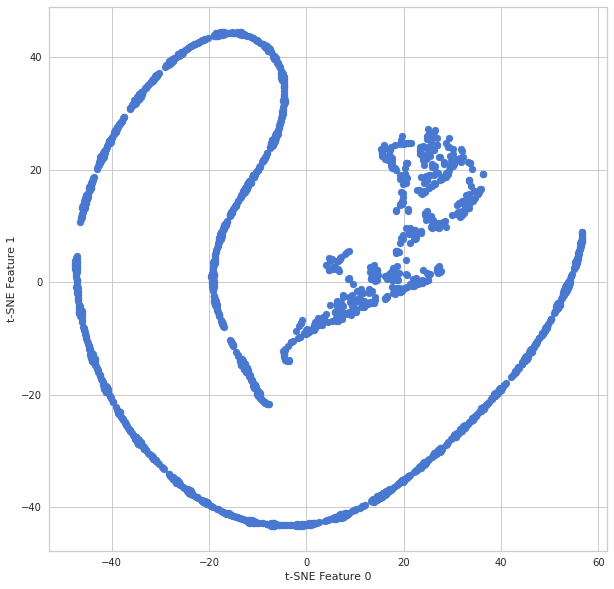

In [ ]:
tsne = TSNE(random_state=42, early_exaggeration=30)
df_tsne = tsne.fit_transform(data_scaled_B)
df_tsne = pd.DataFrame(df_tsne, columns=['First Feature', 'Second Feature'])

plt.figure(figsize=(10, 10))
plt.scatter(df_tsne['First Feature'], df_tsne['Second Feature'])
plt.xlabel('t-SNE Feature 0')
plt.ylabel('t-SNE Feature 1')

##UMAP

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


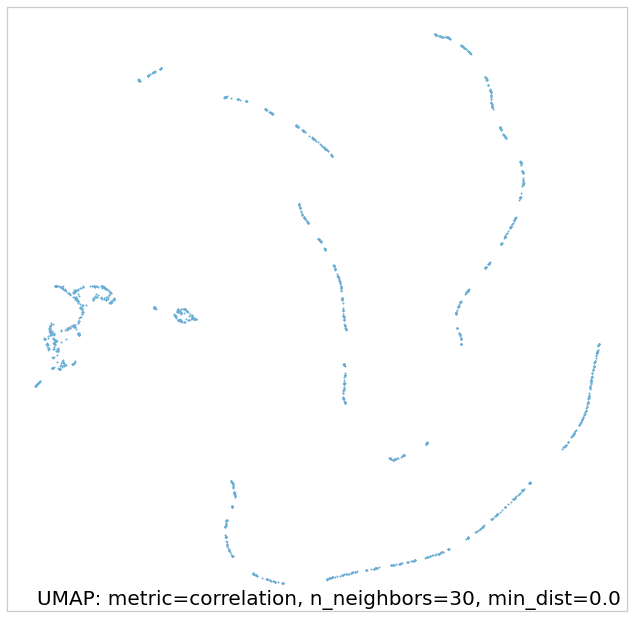

In [ ]:
mapper = umap.UMAP(n_neighbors=30,
                      min_dist=.00,
                      metric='correlation').fit(data_scaled_B)
umap.plot.points(mapper)

UMAP returns overall 4 clusters, including a curvy-shaped cluster on the right.

#Household C Plotting

In [ ]:
new_C_Time = new_C['Time_mins']
new_HH_C=new_C.drop(columns=['start_time','end_time','Roll_ID', 'Roll_Type','Time_mins'], axis=1)
#Scaling 
scaler_C = MinMaxScaler()
result = scaler_C.fit_transform(new_HH_C)
data_scaled_C = pd.DataFrame(result, columns=new_HH_C.columns)
data_scaled_C.describe()

,delta_time,num_sheet_pulls,total_sheets,avg_sheets,max_sheets
count,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000
mean,0.047746,0.048338,0.157753,0.341619,0.300629
std,0.101637,0.089483,0.128580,0.150795,0.138445
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.091837,0.242048,0.217328
50%,0.000000,0.000000,0.127295,0.332954,0.289217
75%,0.040268,0.083333,0.175209,0.431081,0.359687
max,1.000000,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


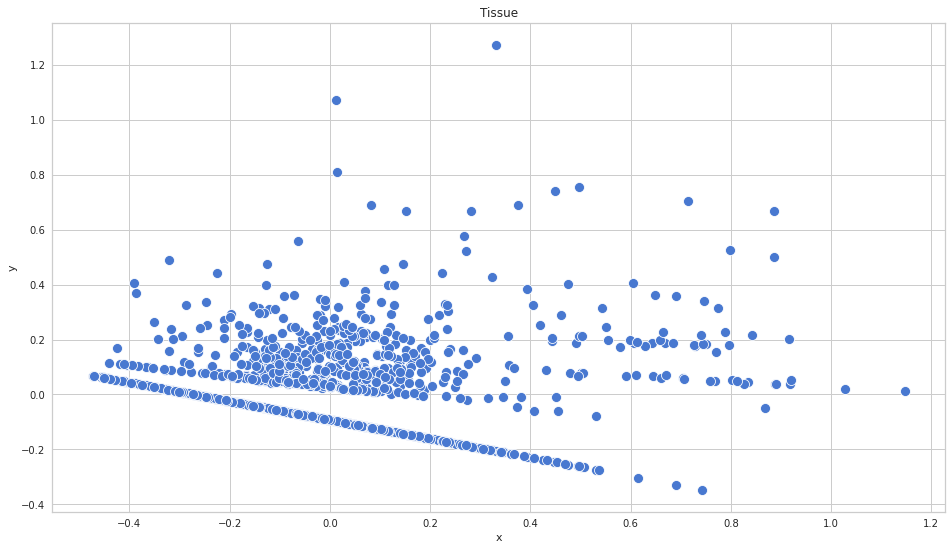

In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(data_scaled_C)
result = pd.DataFrame(result, columns=["x", "y"])

# font define
mlp.rcParams['font.size'] = 20
mlp.rcParams['font.family'] = 'Nanum Gothic'

# visualization
plt.figure(figsize=(16, 9))
sns.set_palette(sns.color_palette("muted"))

sns.scatterplot(result['x'], 
                     result['y'],
                     s=100,
                    )
plt.title('Tissue')
plt.show()

##TSNE

Text(0, 0.5, 't-SNE Feature 1')

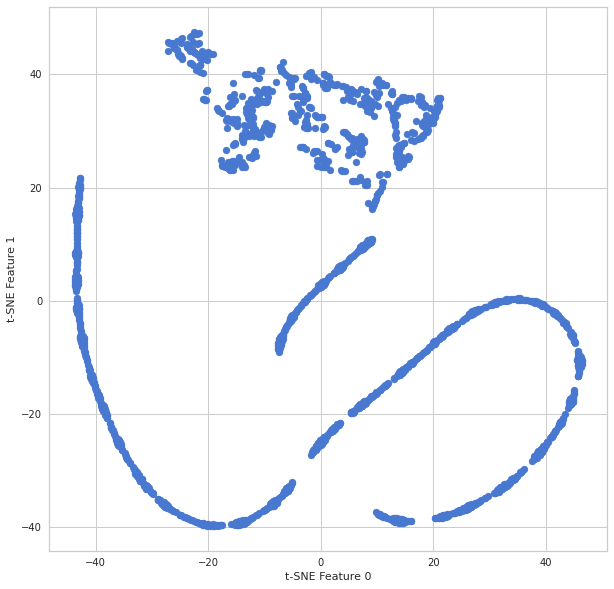

In [ ]:
tsne = TSNE(random_state=42, early_exaggeration=30)
df_tsne = tsne.fit_transform(data_scaled_C)
df_tsne = pd.DataFrame(df_tsne, columns=['First Feature', 'Second Feature'])

plt.figure(figsize=(10, 10))
plt.scatter(df_tsne['First Feature'], df_tsne['Second Feature'])
plt.xlabel('t-SNE Feature 0')
plt.ylabel('t-SNE Feature 1')

##UMAP

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


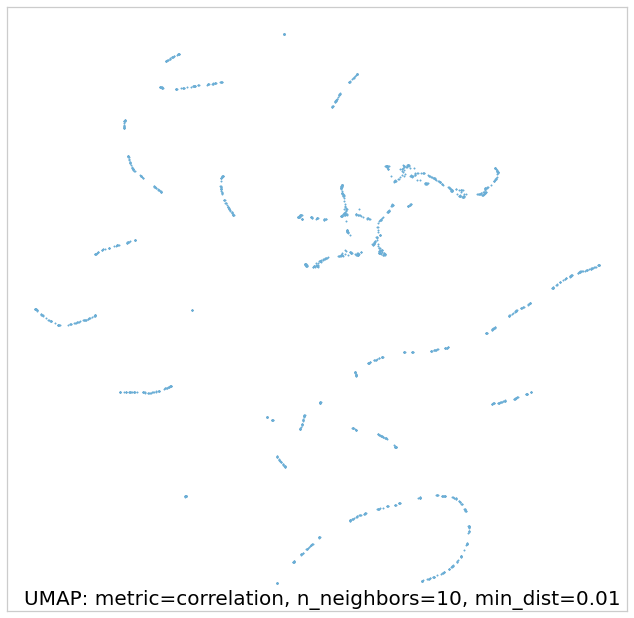

In [ ]:
mapper = umap.UMAP(n_neighbors=10,
                      min_dist=.01,
                      metric='correlation').fit(data_scaled_C)
umap.plot.points(mapper)

Cluster formation is not obvious. It is hard to extract any information from UMAP for household C.

#Household D Plotting

In [ ]:
new_D_Time = new_D['Time_mins']
new_HH_D = new_D.drop(columns=['start_time','end_time','Roll_ID', 'Roll_Type', 'Time_mins'], axis=1)
#Scaling 
scaler_D = MinMaxScaler()
result = scaler_D.fit_transform(new_HH_D)
data_scaled_D = pd.DataFrame(result, columns=new_HH_D.columns)
data_scaled_D.describe()

,delta_time,num_sheet_pulls,total_sheets,avg_sheets,max_sheets
count,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000
mean,0.096786,0.133544,0.200733,0.238431,0.265606
std,0.143978,0.154492,0.160194,0.128614,0.138056
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.069542,0.133699,0.149772
50%,0.039773,0.111111,0.158244,0.224479,0.270954
75%,0.130682,0.222222,0.289616,0.331894,0.369534
max,1.000000,1.000000,1.000000,1.000000,1.000000


##PCA


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


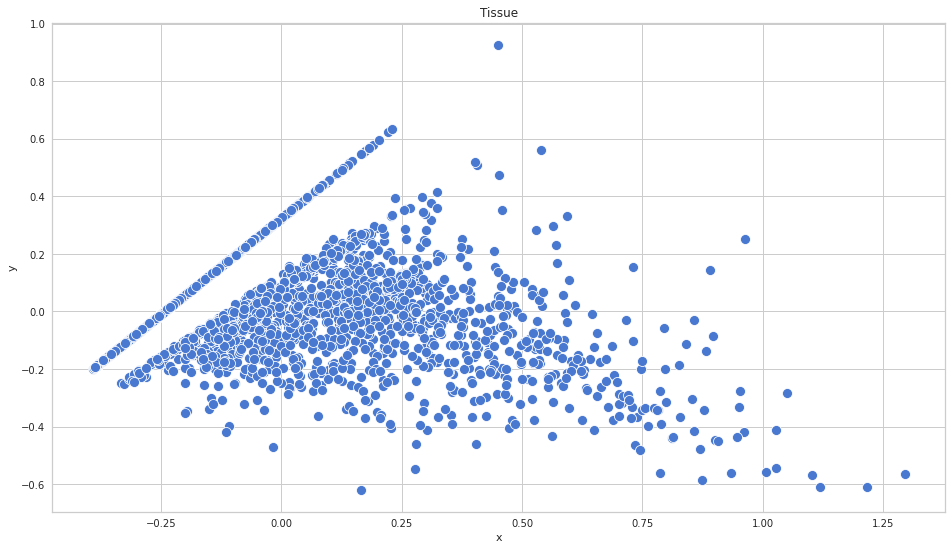

In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(data_scaled_D)
result = pd.DataFrame(result, columns=["x", "y"])

# font define
mlp.rcParams['font.size'] = 20
mlp.rcParams['font.family'] = 'Nanum Gothic'

# visualization
plt.figure(figsize=(16, 9))
sns.set_palette(sns.color_palette("muted"))

sns.scatterplot(result['x'], 
                     result['y'],
                     s=100,
                    )
plt.title('Tissue')
plt.show()

##TSNE

Text(0, 0.5, 't-SNE Feature 1')

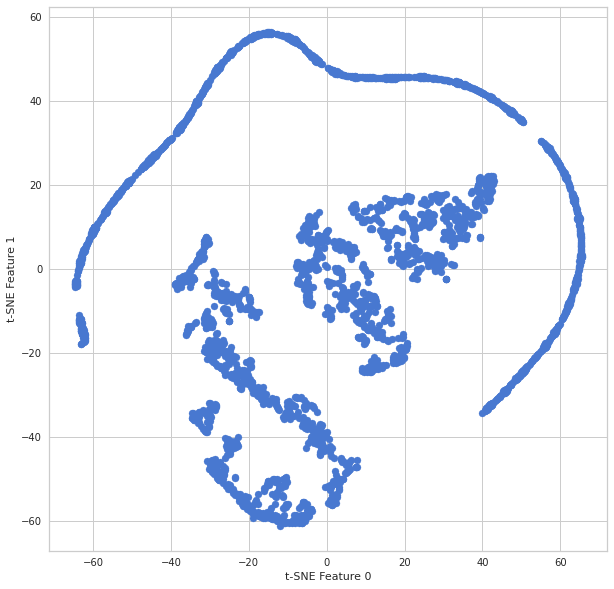

In [ ]:
tsne = TSNE(random_state=42, early_exaggeration=30)
df_tsne = tsne.fit_transform(data_scaled_D)
df_tsne = pd.DataFrame(df_tsne, columns=['First Feature', 'Second Feature'])

plt.figure(figsize=(10, 10))
plt.scatter(df_tsne['First Feature'], df_tsne['Second Feature'])
plt.xlabel('t-SNE Feature 0')
plt.ylabel('t-SNE Feature 1')

t-SNE plot shows 3 clusters in the middle, and a line around the clusters. 
- From the elbow method and silhouette score method we use to decide the number of clusters later on in the notebook, we get 3 clusters for household C.
- We can see that the result from the dimention reduction is somewhat related to the results we got from using elbow and silouette score method.

What is also interesting is that the t-SNE plot and the UMAP plot in the following cell shows a similar pattern. 
- As you can see below, UMAP plot also shows a couple of clusters in the middle, and a curve that are on the edges of the graph.

##UMAP

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


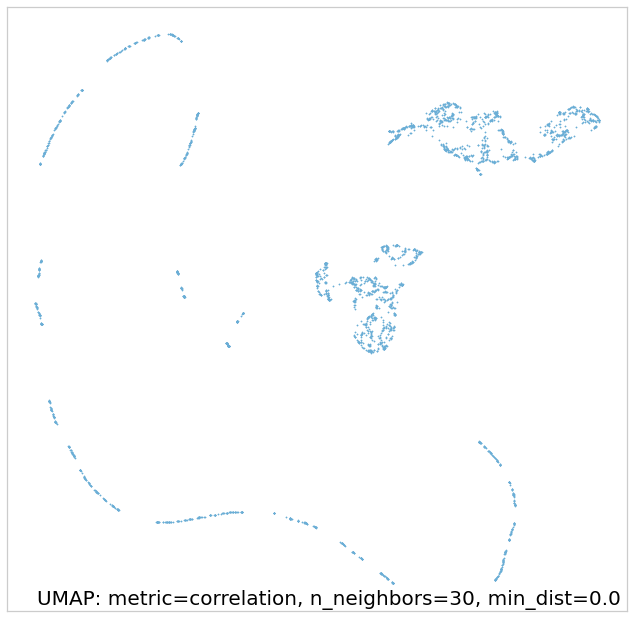

In [ ]:
mapper = umap.UMAP(n_neighbors=30,
                      min_dist=.00,
                      metric='correlation').fit(data_scaled_D)
umap.plot.points(mapper)

#MODELING

`Time_mins` were dropped from data in order to focus on characteristics of tasks itself not by time.

Here's the process of our modeling:

1. Examine the optimal cluster number by using Silhouette Method and Elbow Method.
  - Elbow method is related to the number of entries within clusters and cluster's inertia.
  - The higher the number of entries are, the lower inertia the cluster has.
  - Therefore, the Elbow method is looking for the point where the change of inertia is at least, and that point is called "Elbow".
  - Silhouette score measures how dense the cluster is. The higher the better, and the max score is 1.
2. Apply the K-mean algorithm with the optimal cluster number measured in step 1.
3. Concatenate the original data with the label predicted by K-means. Then the dataset possesses the label and we are allowed to interpret how the cluster has been formed.
4. Make a cluster report using DecisionTreeClassifier so that we can understand the rules of cluster forming.
5. We can also understand the characteristic of each cluster by `K-mean.cluster_center_`. 
6. Do extra analysis on the dataset with labels.

We have tried various algorithms on clustering, but we have concluded that the K-means algorithm is the most proper model.
- K-means is relatively easier to interpret how the model formed the cluster by using `cluster_center_`. 
- We have researched about KPrototypes, the combination of K-mean and K-mode(similar to K-mean but using categorical feature only), but as mentioned above, categorical had a dominant impact on the decision of cluster formation.
- We tried to implement time-series data with our modeling and applied hierarchical clustering with gower distance and dynamic time warping, but the result of clustering wasn't satisfying to turn over the result of K-means. 

In [ ]:
# cluster report

from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

## Household A

Both Silhouette and Elbow method agrees on the identical cluster number, 5. We decided to use 5 as the number of clusters.
- Indeed, cluster number 2 has the highest silhouette score, however, this division of task is too drastic to detect another usage of toilet paper.

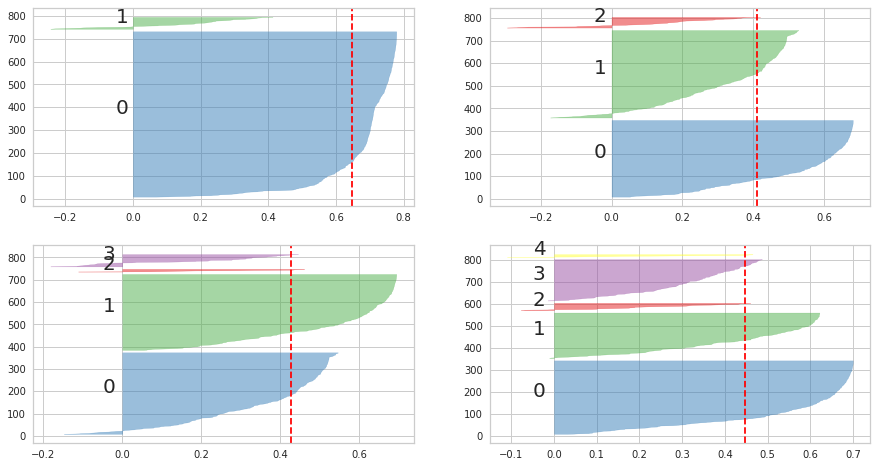

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2, 6):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled_A)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


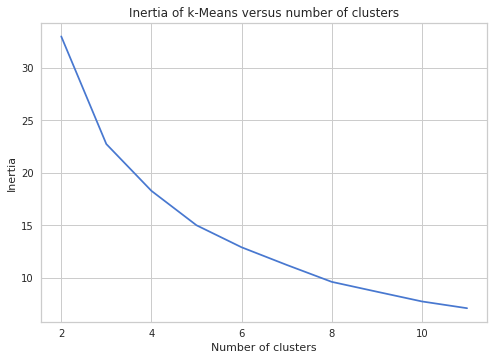

In [ ]:
scores = [KMeans(n_clusters=i+2).fit(data_scaled_A).inertia_ 
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")
plt.show()

In [ ]:
kmeans_A = KMeans(n_clusters=5, random_state=42)
labels_A = kmeans_A.fit(data_scaled_A).labels_
unique, counts = np.unique(labels_A, return_counts=True)
dict(zip(unique, counts))

{0: 334, 1: 207, 2: 34, 3: 188, 4: 13}

In [ ]:
df_a = pd.DataFrame(scaler_A.inverse_transform(data_scaled_A),columns=data_scaled_A.columns)
cluster_report(df_a, labels_A)

,class_name,instance_count,rule_list
0,0,334,[1.0] (avg_sheets > 4.502441167831421) and (total_sheets <= 8.772467613220215)[0.46] (avg_sheets > 4.502441167831421) and (total_sheets > 8.772467613220215)
1,1,207,[0.961352657004831] (avg_sheets <= 4.502441167831421) and (total_sheets <= 4.540815830230713)
3,2,34,[0.54] (avg_sheets <= 4.502441167831421) and (total_sheets > 4.540815830230713) and (delta_time > 0.24166666716337204)
2,3,188,[0.9556962025316456] (avg_sheets <= 4.502441167831421) and (total_sheets > 4.540815830230713) and (delta_time <= 0.24166666716337204)
4,4,13,NaN


In [ ]:
pd.DataFrame(scaler_A.inverse_transform(kmeans_A.cluster_centers_),columns=data_scaled_A.columns)

,delta_time,num_sheet_pulls,total_sheets,avg_sheets,max_sheets
0,0.008782,1.044910,6.499961,6.228451,6.328351
1,0.019243,1.198068,2.952723,2.655037,2.795940
2,1.372549,4.294118,12.884731,3.129794,5.594300
3,0.124645,2.292553,7.248703,3.219861,5.227398
4,0.487179,4.230769,35.776768,10.365149,13.205899


#### Modeling Analysis

Text(0.5, 17.6, 'Hours')

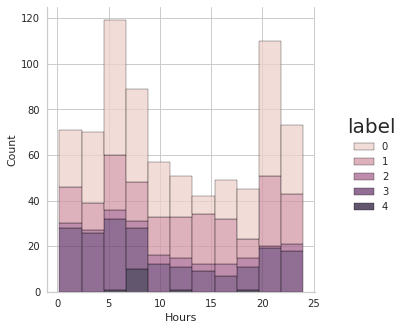

In [ ]:
new_A['label'] =kmeans_A.labels_
sns.displot(new_A, x=new_A["Time_mins"]/60, hue="label", multiple='stack')
plt.xlabel('Hours')

Here's our assumption on the task:
- 0: Usage on the urine with the case of menstruation.
- 1: Usage on the urine.
- 2: Usage on the defecation.
- 3: Baby: Changing of a diaper.
- 4: Usage on cleaning

And here's the explanation:
- Task 0 has a similar characteristic with task 1 but has a drastic increase of usage in the morning and evening. We presume that this particular increase includes the use on menstruation, before and after working.
- Task 1 has been identically distributed throughout the day. Also, the number of sheet pulls is close to 1 and the number of the sheet is relatively small. Therefore we assume that this task involves with urinal action of the female.
- Task 2 has apparent evidence to support this action involved in defecation. The number of sheet pulls, the total number of sheets and the number of the average sheet are relatively higher than other tasks. 
- Household A has a unique identifier that differs from other households. Task 3 has been executed in the daybreak, which is difficult to understand. We presume this as the presence of the baby. The baby is not the entity that involves in toilet paper usage. That is why the number of household A is 2, and this action in the daybreak supports the possible presense of the baby.
- Task 4 is also a unique action that differs from other actions. This task doesn't happen at both daybreak and night. Also, this task usually happens in the morning. We assume that this task is involved in cleaning. With this data, we can also assume that household A prefers to clean up the house in the morning.

Lastly, let's see which feature has a major affect on cluster forming.

In [ ]:
new_A.corr()

,Roll_ID,delta_time,Time_mins,num_sheet_pulls,total_sheets,avg_sheets,max_sheets,label
Roll_ID,1.000000,-0.141246,-0.239759,-0.050387,0.122685,0.275031,0.262572,-0.082830
delta_time,-0.141246,1.000000,0.012618,0.663509,0.471694,-0.117299,0.104095,0.303546
Time_mins,-0.239759,0.012618,1.000000,-0.064929,-0.070336,-0.018182,-0.074868,-0.107244
num_sheet_pulls,-0.050387,0.663509,-0.064929,1.000000,0.631176,-0.259006,0.160323,0.628641
total_sheets,0.122685,0.471694,-0.070336,0.631176,1.000000,0.428037,0.699433,0.328477
avg_sheets,0.275031,-0.117299,-0.018182,-0.259006,0.428037,1.000000,0.846502,-0.414074
max_sheets,0.262572,0.104095,-0.074868,0.160323,0.699433,0.846502,1.000000,-0.019148
label,-0.082830,0.303546,-0.107244,0.628641,0.328477,-0.414074,-0.019148,1.000000


`num_sheet_pulls` is positively correlated with the label the most.
- This is very obivous result since logically the number of sheet pull divides the usage on urinal and defecation.

## Household B

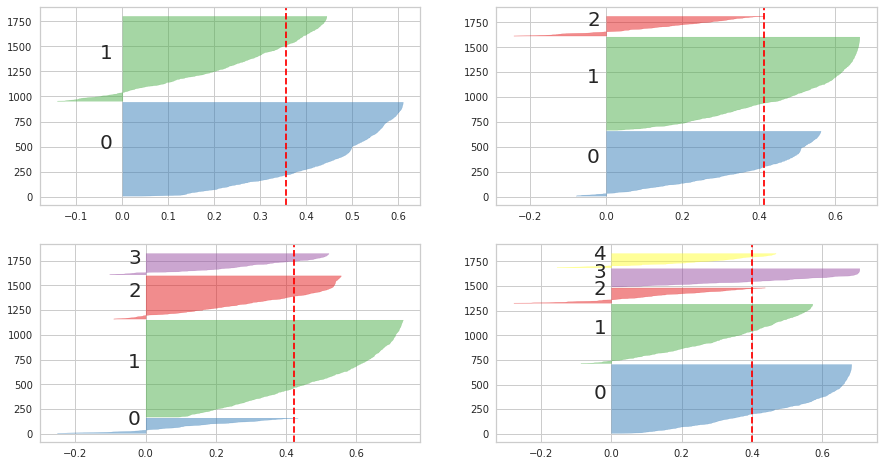

In [ ]:

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2, 6):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled_B)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

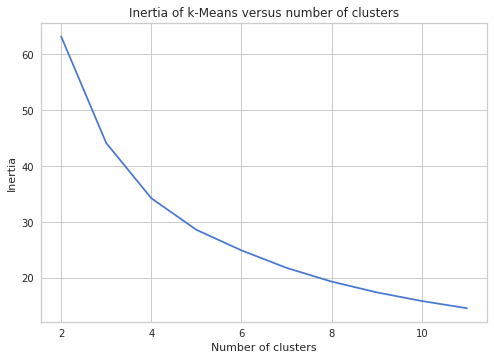

In [ ]:
scores = [KMeans(n_clusters=i+2).fit(data_scaled_B).inertia_ 
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Since the silhouette score is maximised at 4 clusters. Also, the slope of the line graph starts to decrease by a noticeable margin at 4 clusters. Therefore we grouped the tasks of household B into 4 distinct groups.

In [ ]:
kmeans_B = KMeans(n_clusters=4, random_state=42) # cluster 값은 차원 축소 이후에 결정.
labels_B = kmeans_B.fit(data_scaled_B).labels_
unique, counts = np.unique(labels_B, return_counts=True)
dict(zip(unique, counts))

{0: 154, 1: 980, 2: 437, 3: 215}

In [ ]:
df_b = pd.DataFrame(scaler_B.inverse_transform(data_scaled_B),columns=data_scaled_B.columns)
cluster_report(df_b, labels_B)

,class_name,instance_count,rule_list
3,0,154,[0.84] (max_sheets > 3.421263813972473) and (max_sheets <= 6.260597467422485) and (avg_sheets > 2.669499397277832) and (delta_time > 0.4749999940395355)[0.9622641509433962] (max_sheets > 3.421263813972473) and (max_sheets > 6.260597467422485) and (num_sheet_pulls > 2.5)
0,1,980,[0.9763617677286742] (max_sheets > 3.421263813972473) and (max_sheets <= 6.260597467422485) and (avg_sheets > 2.669499397277832) and (delta_time <= 0.4749999940395355)
1,2,437,[0.9864864864864865] (max_sheets <= 3.421263813972473)[0.825] (max_sheets > 3.421263813972473) and (max_sheets <= 6.260597467422485) and (avg_sheets <= 2.669499397277832)
2,3,215,[0.8808510638297873] (max_sheets > 3.421263813972473) and (max_sheets > 6.260597467422485) and (num_sheet_pulls <= 2.5)


In [ ]:
pd.DataFrame(scaler_B.inverse_transform(kmeans_B.cluster_centers_),columns=data_scaled_B.columns)

,delta_time,num_sheet_pulls,total_sheets,avg_sheets,max_sheets
0,1.111580,3.344156,12.859169,4.162846,6.314949
1,0.025348,1.141692,5.159735,4.648976,4.866140
2,0.075726,1.497706,2.752435,1.909383,2.370550
3,0.078605,1.251163,8.963796,7.359892,7.665230


####Modeling Analysis

Text(0.5, 17.6, 'Hours')

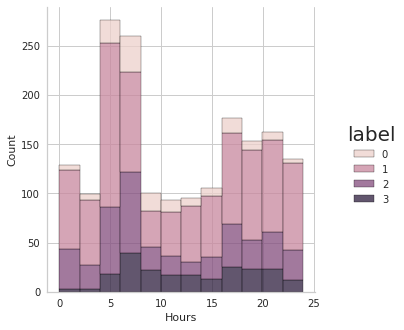

In [ ]:
new_B['label'] =kmeans_B.labels_
sns.displot(new_B, x=new_B["Time_mins"]/60, hue="label", multiple='stack')
plt.xlabel('Hours')

Here's our assumption on the task:
- 0: Usage on defecation.
- 1: Usage on urine.
- 2: Usage on minor cleaning.
- 3: Usage on major cleaning.

And here's the explanation:
- Task 0's numbers indicates that the bathroom user pulled the toilet paper multiple times over a relatively long period of time, and the number of total sheets used are clearly higher than other bathroom tasks. So we assume it is usage on defecation.

- While doing Task 1, the person usually pulled the sheets once or twice, and pulled total 5 sheets of toilet paper on average. The total sheets usage is quite low, so it is likely for Task 1 to be urination. 

- As for Task 2, the number of total sheets used as well as that of the maximum number of sheets used is very low, and the number of pulls is again, once or twice. With this information, we can infer that Task 2 was some minor bathroom task like wiping something off the fingers or cleaning the mirror.

- Task 3 shows relatively high number of total sheets usage and high average sheets per pull, while the number of pulls is low. This means that the person grabbed most of the toilet paper in one shot, which means they know what they are doing. Therefore, Task 3 is likely to be something more serious than Task 2: For example, cleaning dog poop or spilled water.

## Household C

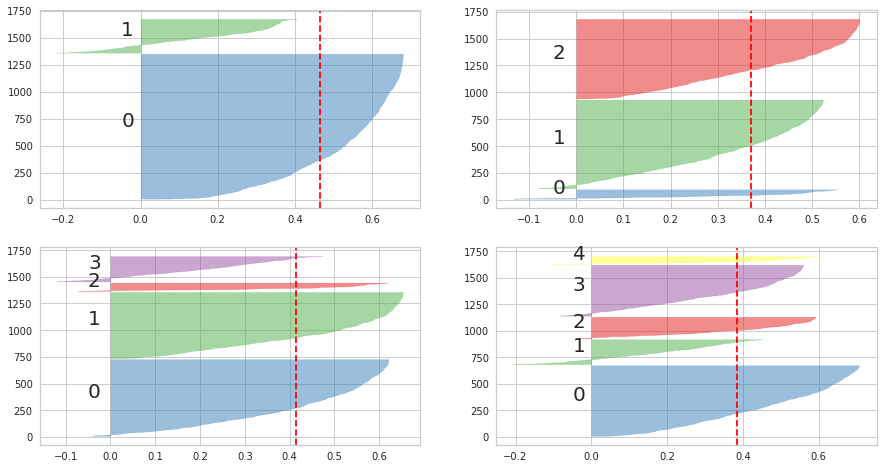

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2, 6):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled_C)

Silhoueette score shows that 2 or 4 clusters are best. However since we want to know more than just pee and poop we decided to use 4 clusters.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

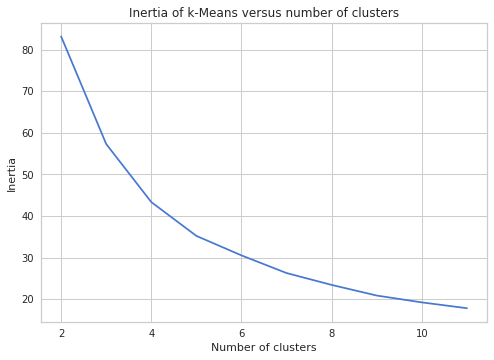

In [ ]:
scores = [KMeans(n_clusters=i+2).fit(data_scaled_C).inertia_ 
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [ ]:
kmeans_C = KMeans(n_clusters=4,random_state=42) # cluster 값은 차원 축소 이후에 결정.
labels_C = kmeans_C.fit(data_scaled_C).labels_
unique, counts = np.unique(labels_C, return_counts=True)
dict(zip(unique, counts))

{0: 719, 1: 620, 2: 78, 3: 238}

In [ ]:
df_c = pd.DataFrame(scaler_C.inverse_transform(data_scaled_C),columns=data_scaled_C.columns)
cluster_report(df_c, labels_C)

,class_name,instance_count,rule_list
0,0,719,[0.9897959183673469] (avg_sheets <= 4.655436992645264) and (delta_time <= 0.49166665971279144) and (total_sheets <= 7.722273588180542)
1,1,620,[0.4727272727272727] (avg_sheets <= 4.655436992645264) and (delta_time <= 0.49166665971279144) and (total_sheets > 7.722273588180542)[0.9894551845342706] (avg_sheets > 4.655436992645264) and (delta_time <= 0.25833334028720856)
3,2,78,[1.0] (avg_sheets > 4.655436992645264) and (delta_time > 0.25833334028720856) and (total_sheets > 19.044166564941406)
2,3,238,[0.8526315789473684] (avg_sheets <= 4.655436992645264) and (delta_time > 0.49166665971279144)[0.6741573033707865] (avg_sheets > 4.655436992645264) and (delta_time > 0.25833334028720856) and (total_sheets <= 19.044166564941406)


In [ ]:
pd.DataFrame(scaler_C.inverse_transform(kmeans_C.cluster_centers_),columns=data_scaled_C.columns)

,delta_time,num_sheet_pulls,total_sheets,avg_sheets,max_sheets
0,0.057812,1.353268,3.872121,3.054819,3.421801
1,0.032097,1.112903,6.572273,6.001761,6.209501
2,0.710470,3.666667,26.783009,7.794530,11.467876
3,1.157913,2.798319,9.869717,3.846541,5.155755


####Modeling Analysis

Text(0.5, 17.6, 'Hours')

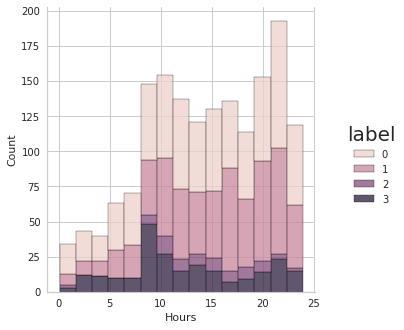

In [ ]:
new_C['label'] =kmeans_C.labels_
sns.displot(new_C, x=new_C["Time_mins"]/60, hue="label", multiple='stack')
plt.xlabel('Hours')

Here's our assumption on the task:
- 0: Usage on the urine of female.
- 1: Usage on the urine of male.
- 2: Usage on cleaning: Possibly pet's urine or defecation
- 3: Usage on the defecation.

And here's the explanation:

- There are lots of usage of toilet paper during the usual work hour (9:00 to 17:00) compared to other household since 65 years old people in household C are not likely to go to work.

- Task 0 and 1 seems to have similar distribution but the difference with number of sheets they have used. Their number of sheet pulled and total sheets pulled are relatively smaller than other. Their number of sheet pulled is nearly 1.  Also, 0 and 1 are observed in the early morning and this can be explained by weakened sphincters of elders. By these reasons, we assume these task involves urinal actions.

- Since we assume female uses more toilet papers than man during urinal actions, Task 0 is assumed to be urinal action of female and Task 1 is assumed to be urinal action of man in household C.

- Task 2 shows the greatest total_sheets with number of sheet pulled. The biggest difference we could have noticed from Task 3 is that Task 2 is not found in during day break and the delta time is less than Task 3. After considering these factors we assumed the Task 2 involves cleaning action. However, since the distribution along the Time_mins are similar to others, it can be assumed that it involves cleaning of their pet's either urinal or defecation activity if they have a pet.

- Task 3 has the longest delta_time and larger total_sheets and number of sheet_pulled compared to others so we assume Task 3 involves the defecation activity.

## Household D

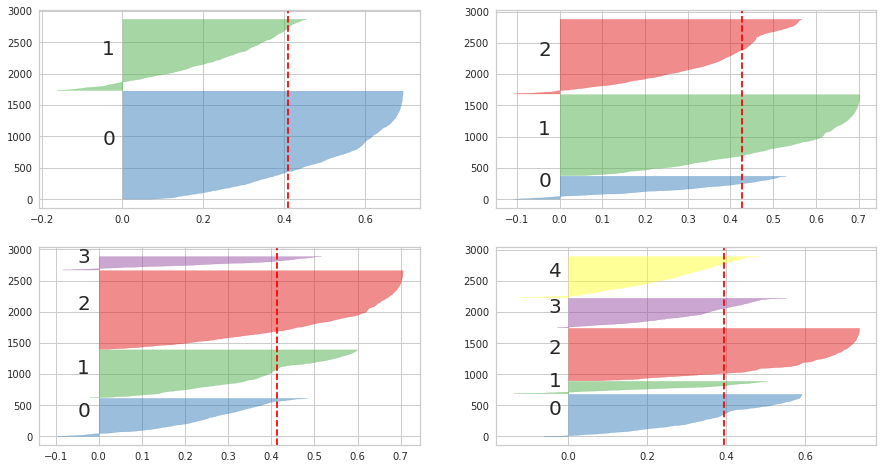

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2, 6):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled_D)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

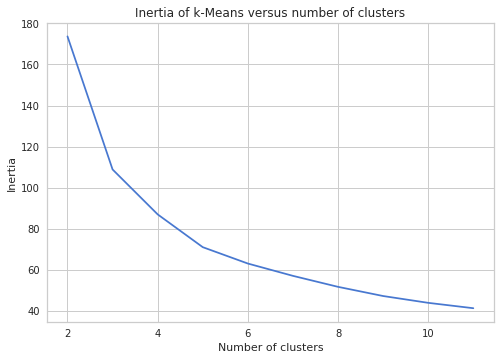

In [ ]:
scores = [KMeans(n_clusters=i+2).fit(data_scaled_D).inertia_ 
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Since the silhouette score is maximised at 3 clusters. Also, the slope of the line graph starts to decrease by a noticeable margin at 3 clusters. Therefore we grouped the tasks of household D into 3 distinct groups.

In [ ]:
kmeans_D = KMeans(n_clusters=3,random_state=42) 
labels_D = kmeans_D.fit(data_scaled_D).labels_
unique, counts = np.unique(labels_D, return_counts=True)
dict(zip(unique, counts))

{0: 366, 1: 1294, 2: 1193}

In [ ]:
df_d = pd.DataFrame(scaler_D.inverse_transform(data_scaled_D),columns=data_scaled_D.columns)
cluster_report(df_d, labels_D)

,class_name,instance_count,rule_list
2,0,366,[0.578125] (max_sheets <= 6.019334077835083) and (total_sheets > 12.153168201446533)[0.9758620689655172] (max_sheets > 6.019334077835083) and (num_sheet_pulls > 3.5) and (delta_time > 0.4583333283662796)
0,1,1294,[0.9878542510121457] (max_sheets <= 6.019334077835083) and (total_sheets <= 12.153168201446533)[0.82] (max_sheets > 6.019334077835083) and (num_sheet_pulls <= 3.5) and (max_sheets <= 6.726205348968506) and (total_sheets <= 10.66223669052124)
1,2,1193,[0.9661016949152542] (max_sheets > 6.019334077835083) and (num_sheet_pulls <= 3.5) and (max_sheets <= 6.726205348968506) and (total_sheets > 10.66223669052124)[0.963669391462307] (max_sheets > 6.019334077835083) and (num_sheet_pulls <= 3.5) and (max_sheets > 6.726205348968506)[0.6666666666666666] (max_sheets > 6.019334077835083) and (num_sheet_pulls > 3.5) and (delta_time <= 0.4583333283662796)


In [ ]:
pd.DataFrame(scaler_D.inverse_transform(kmeans_D.cluster_centers_),columns=data_scaled_D.columns)

,delta_time,num_sheet_pulls,total_sheets,avg_sheets,max_sheets
0,1.128734,4.926230,29.362469,6.111587,8.503928
1,0.110188,1.557187,4.775800,3.045300,3.497144
2,0.213146,2.065381,15.249453,7.882875,9.094571


Text(0.5, 17.6, 'Hours')

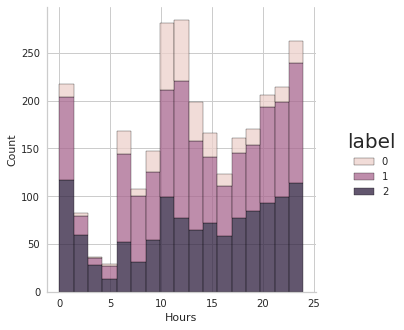

In [ ]:
new_D['label'] =kmeans_D.labels_
sns.displot(new_D, x=new_D["Time_mins"]/60, hue="label", multiple='stack')
plt.xlabel('Hours')

Here's our assumption on the task:
- 0: Usage on cleaning
- 1: Usage on urine
- 2: Usage on defecation

And here's the explanation:
- Task 0's numbers show that people from household D uses the total of sheets, and 2 pulls within a short interval. Looking at the overall table, we noticed that thier toilet paper usage is high compared to people from other households.
Since there is no data on daybreak, we assume it is a usage on cleaning.

- The overall toilet paper usage for Task 1 is extremely low considering the fact that they tend to use a lot of toilet paper in general. Therefore, we assume it is a usage on urine.

- Task 2 shows high numbers throughout all columns, which means they stayed in the bathroom for a while, used a fair amount of toilet paper, and had to pull the sheets multiple times. This is a clear indication that Task 2 was usage on defecation.

#Business Insight


1. Toilet Paper Usage Pattern
2. Detect abnormal health status
3. Target advertisement time

###Characteristics of Households Observed from EDA

Household A:
- Young married couple working from home

Household B:
- Middle-aged married couple after retirement
- Possible to have a guest


Household C:
- Old-aged married couple spending their most time at home


Household D:
- One goes to work, the other stays at home
- Possible to have guests


## 1. Toilet Paper Usage Pattern

In [ ]:
from matplotlib.cbook import boxplot_stats
defecation_A=new_A[new_A['label']==2]
defecation_B=new_B[new_B['label']==0]
defecation_C = new_C[new_C['label']==3]
defecation_D = new_D[new_D['label']==2]

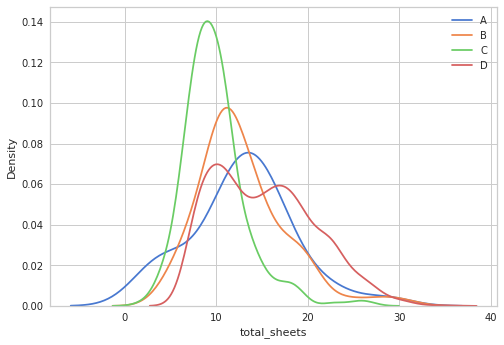

In [ ]:
plt.figure("Plots")
fig=sns.kdeplot(defecation_A['total_sheets'],Label='A')
fig=sns.kdeplot(defecation_B['total_sheets'],Label ='B')
fig=sns.kdeplot(defecation_C['total_sheets'],Label ='C')
fig=sns.kdeplot(defecation_D['total_sheets'],Label ='D')

plt.legend()

We can compare the density plot of their total usage for each defecation task.

 - D > A > B > C  is the order of total sheet usage 
 
It is better to target household with more usage in seller's perspective

##2. Detecting Abnormal Health 

###How to detect abnormal health data and use.
- Explained with Household A as an example.

Check if there is an outlier.

['fliers']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


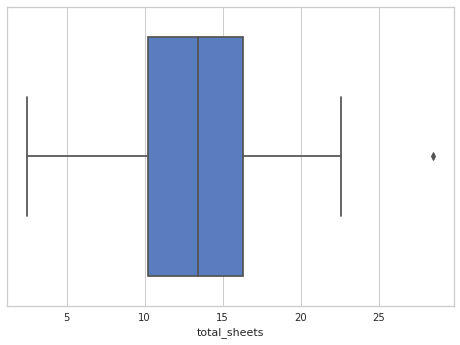

In [ ]:
sns.boxplot(defecation_A['total_sheets'])
outliers = [y for stat in boxplot_stats(new_A['total_sheets']) for y in ['fliers']]
print(outliers)

In [ ]:
def outlier(df, target):
  P = np.percentile(df[target], [5, 75])
  new_df = df[(df[target] > P[1])]
  return new_df

Using outliers function, we can detect the abnormal day that users got sick.

In [ ]:
outlier(defecation_A,'delta_time').merge(outlier(defecation_A,'total_sheets'),how='inner')

,Roll_ID,Roll_Type,start_time,end_time,delta_time,Time_mins,num_sheet_pulls,total_sheets,avg_sheets,max_sheets,label
0,0,Small,2019-11-01 11:18:03,2019-11-01 11:20:18,2.250000,678,4,21.560813,5.390203,10.459623,2
1,4,Small,2019-10-02 06:24:13,2019-10-02 06:25:53,1.666667,384,4,17.334756,4.333689,8.017089,2
2,6,Small,2019-10-19 05:49:04,2019-10-19 05:50:59,1.916667,349,6,22.568276,3.761379,7.917288,2
3,6,Small,2019-10-19 07:25:06,2019-10-19 07:27:12,2.100000,445,4,16.833491,4.208373,6.768410,2
4,7,Big,2020-06-30 18:26:41,2020-06-30 18:29:16,2.583333,1106,5,28.493551,5.698710,8.179737,2


Finding the dates by abnormal time spent on bathroom and abnormal usage of toilet paper. 
- These data set possibly includes diarrhea and we could use this sensor connected to device such as apple watch and inlcude this data to the health database to keep track of the user's health status and diagnose.

##3. Target Advertisement Time

### Compare when and how long for effective time for advertising
  Since most people use their phone and watch Youtube during defecation, we can collect the data of when and how long for each household and find the best time to show the right advertisement for each household.

We can find when people are mostly staying in toilet for defecaiton using density plot.

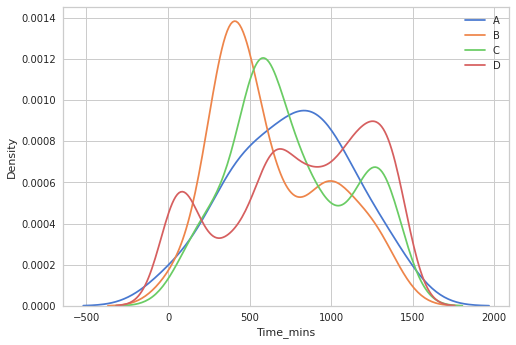

In [ ]:
plt.figure('Time of Usage')
fig=sns.kdeplot(defecation_A['Time_mins'],Label='A')
fig=sns.kdeplot(defecation_B['Time_mins'],Label='B')
fig=sns.kdeplot(defecation_C['Time_mins'],Label='C')
fig=sns.kdeplot(defecation_D['Time_mins'],Label ='D')
plt.legend()

We can compare how long people are in the toilet for defecaiton.

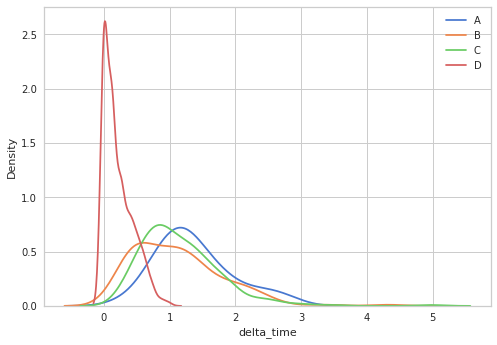

In [ ]:
plt.figure("How long Usage")
fig=sns.kdeplot(defecation_A['delta_time'],Label='A')
fig=sns.kdeplot(defecation_B['delta_time'],Label ='B')
fig=sns.kdeplot(defecation_C['delta_time'],Label ='C')
fig=sns.kdeplot(defecation_D['delta_time'],Label ='D')
plt.legend()

Since Household A stays longer than other, we would suggest start targeting them for advertisement with the time data above.

###Conclusion

- From the 1.Toilet Paper Usage Pattern, we observed who can be a best consumer for the toilet paper products.
- From the 2.Detecting Abnormal Health, we observed health status of target consumers.
- From the 3.Target Advertisement Time, we observed who can be more exposed to the product's advertisement and when the most effective time interval is.


These data can be used synchronously,

- Example 1: with 1 and 3, toilet paper advertisement can be exposed to the targetted best consumer in effective time 

- Example 2: With 2 and 3, advertisement of proper health related products for each household can be shown in the effective time for each household.